In [1]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install imblearn
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import gc
import joblib
from collections import Counter
from tqdm import tqdm
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.optimize import minimize
from imblearn.over_sampling import SMOTE, ADASYN

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.utils import resample, compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score,
                           roc_curve, classification_report, mean_squared_error,
                           precision_recall_curve, average_precision_score)
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, Dense, Dropout, BatchNormalization,
                                   Bidirectional, Input, Concatenate, GRU,
                                   GaussianNoise, Lambda, Multiply, Add)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.000,PERSONAL,D,35000,16.020,1,0.590,Y,3
1,21,9600,OWN,5.000,EDUCATION,B,1000,11.140,0,0.100,N,2
2,25,9600,MORTGAGE,1.000,MEDICAL,C,5500,12.870,1,0.570,N,3
3,23,65500,RENT,4.000,MEDICAL,C,35000,15.230,1,0.530,N,2
4,24,54400,RENT,8.000,MEDICAL,C,35000,14.270,1,0.550,Y,4


In [5]:
df.shape

(32581, 12)

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000,32581.000,31686.000,32581.000,29465.000,32581.000,32581.000,32581.000
mean,27.735,66074.848,4.790,9589.371,11.012,0.218,0.170,5.804
std,6.348,61983.119,4.143,6322.087,3.240,0.413,0.107,4.055
min,20.000,4000.000,0.000,500.000,5.420,0.000,0.000,2.000
25%,23.000,38500.000,2.000,5000.000,7.900,0.000,0.090,3.000
50%,26.000,55000.000,4.000,8000.000,10.990,0.000,0.150,4.000
75%,30.000,79200.000,7.000,12200.000,13.470,0.000,0.230,8.000
max,144.000,6000000.000,123.000,35000.000,23.220,1.000,0.830,30.000


In [7]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


In [8]:
print(f"Kolom Duplikat: {df.duplicated().sum()}")
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Kolom Duplikat: 165


,0
person_emp_length,895
loan_int_rate,3116


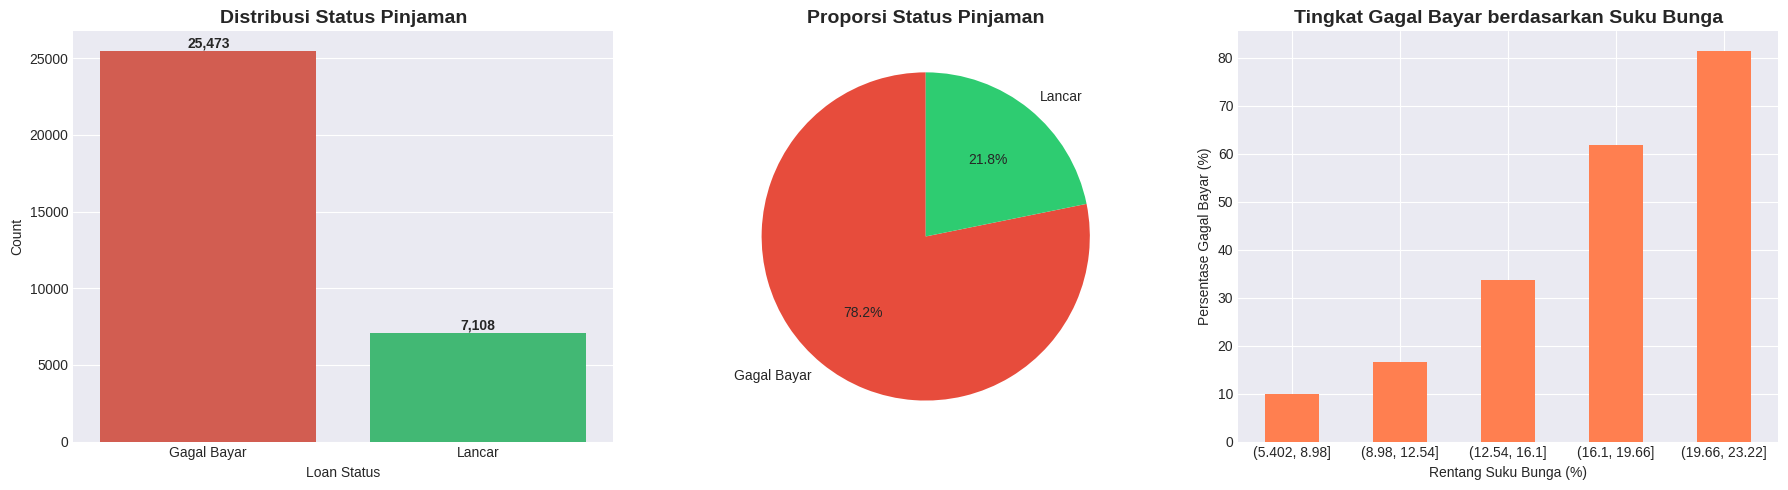

In [9]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='loan_status', palette=['#e74c3c', '#2ecc71'])
plt.title('Distribusi Status Pinjaman', fontsize=14, fontweight='bold')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Gagal Bayar', 'Lancar'])

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 3, 2)
df['loan_status'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#e74c3c', '#2ecc71'],
    labels=['Gagal Bayar', 'Lancar'],
    startangle=90
)
plt.title('Proporsi Status Pinjaman', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.subplot(1, 3, 3)
risk_analysis = df.groupby(pd.cut(df['loan_int_rate'], bins=5))['loan_status'].agg(['sum', 'count', 'mean'])
risk_analysis['persen_gagal_bayar'] = risk_analysis['mean'] * 100
risk_analysis['persen_gagal_bayar'].plot(kind='bar', color='coral')
plt.title('Tingkat Gagal Bayar berdasarkan Suku Bunga', fontsize=14, fontweight='bold')
plt.xlabel('Rentang Suku Bunga (%)')
plt.ylabel('Persentase Gagal Bayar (%)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [10]:
profil_risiko = df.groupby('loan_status')[['loan_int_rate', 'loan_percent_income']].mean()
profil_risiko.head()

,loan_int_rate,loan_percent_income
loan_status,,
0,10.436,0.149
1,13.060,0.247


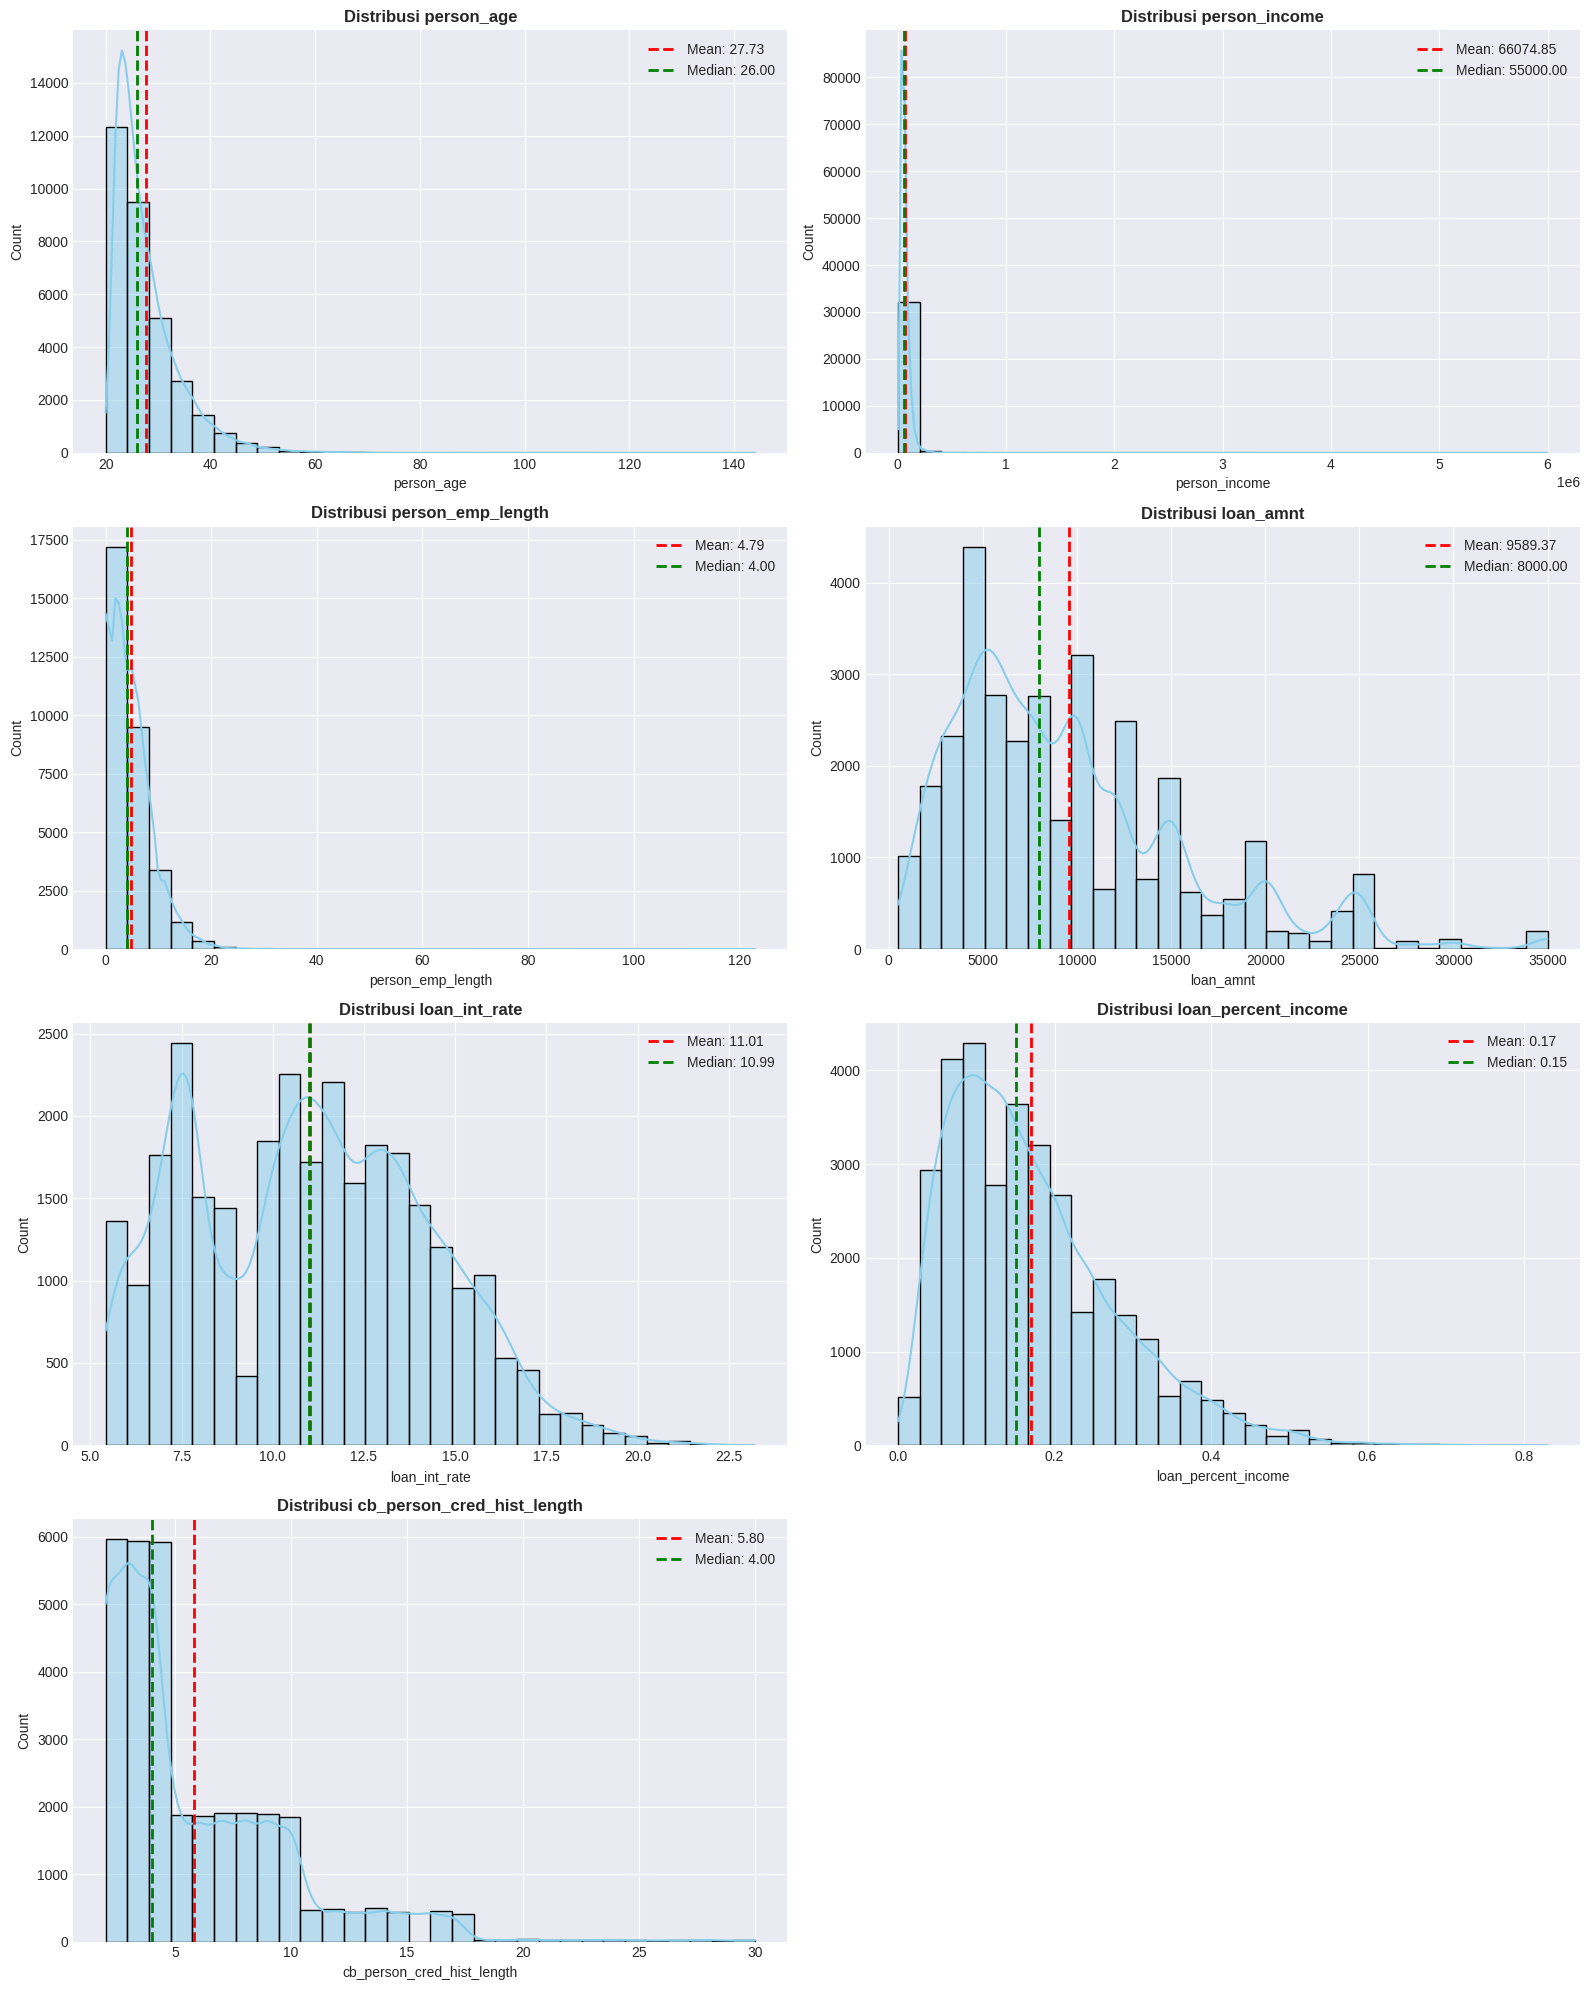

In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('loan_status')

plt.figure(figsize=(16, 20))

for idx, col in enumerate(numeric_cols):
    plt.subplot(4, 2, idx + 1)
    sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribusi {col}', fontsize=12, fontweight='bold')
    plt.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df[col].mean():.2f}')
    plt.axvline(df[col].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {df[col].median():.2f}')
    plt.legend()

plt.tight_layout()
plt.show()

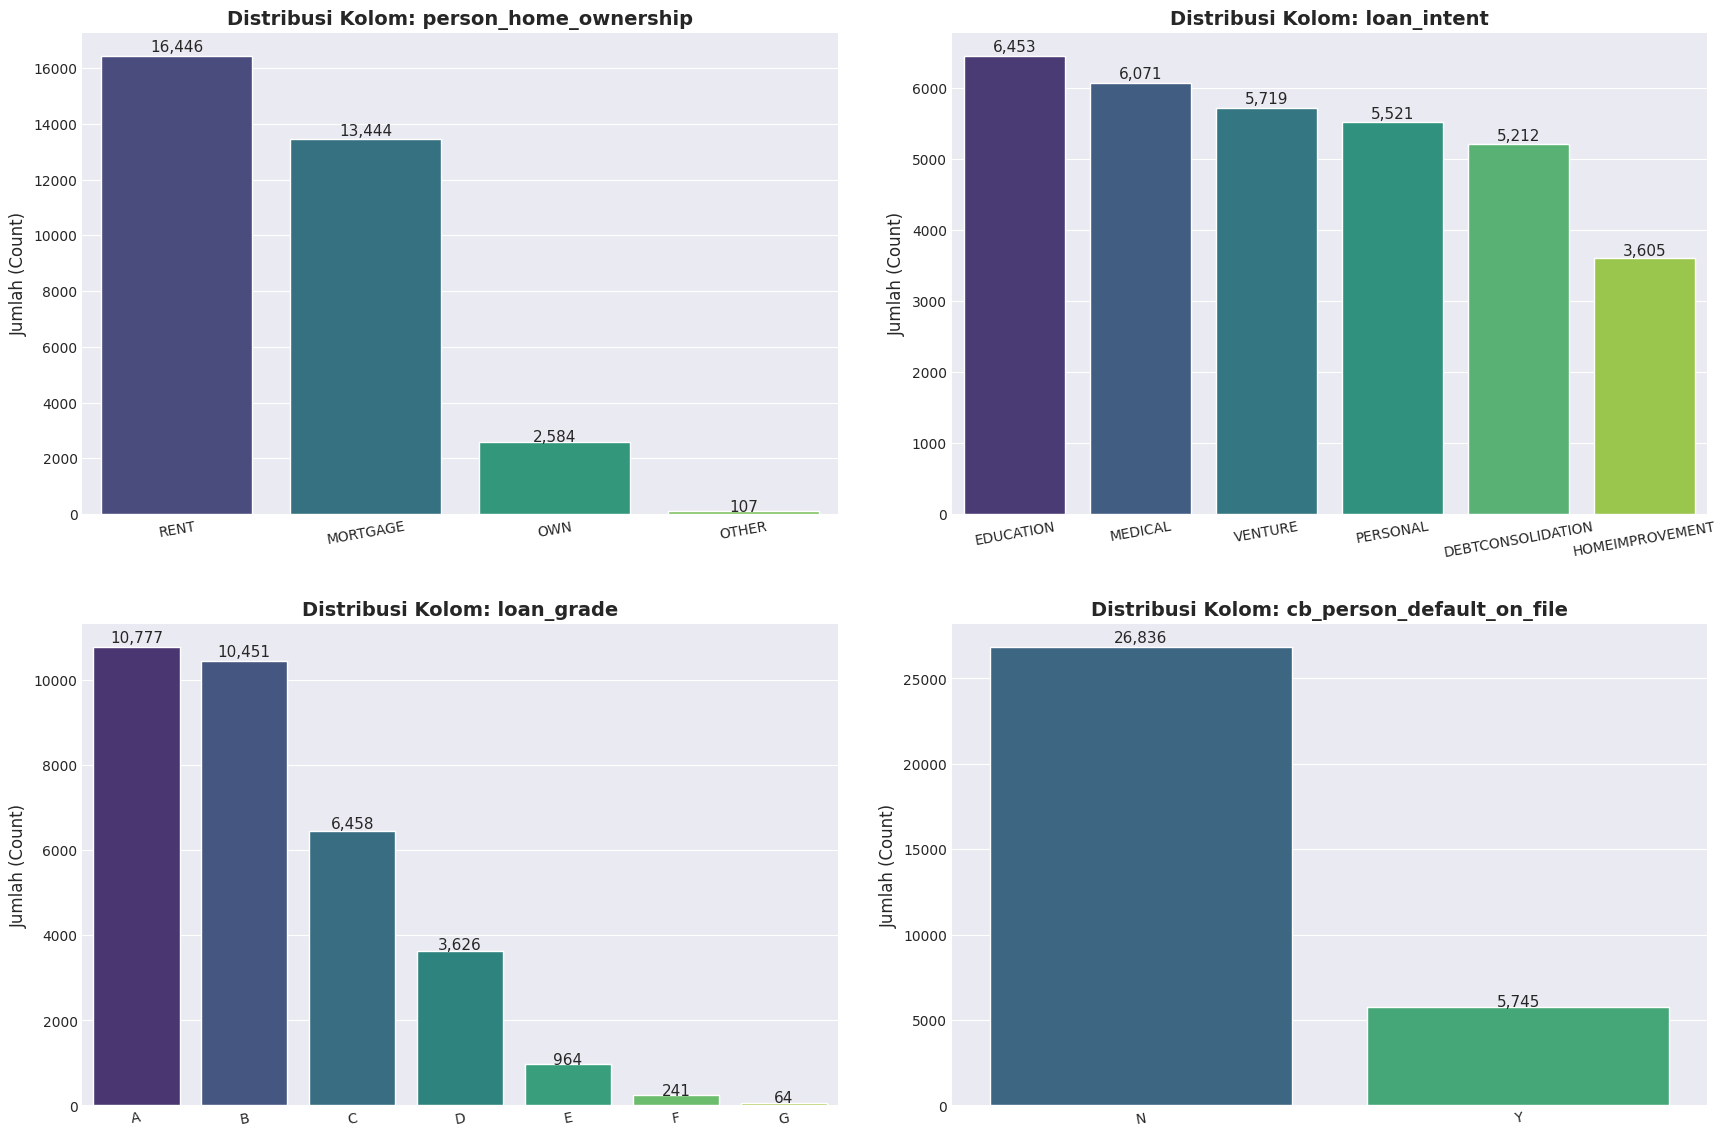

In [12]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

sns.set_style("darkgrid")
plt.figure(figsize=(18, 12))

for idx, col in enumerate(categorical_cols[:4]):
    ax = plt.subplot(2, 2, idx + 1)
    sns.countplot(
        data=df,
        x=col,
        palette='viridis',
        order=df[col].value_counts().index
    )

    for p in ax.patches:
        count = int(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y + (count * 0.01), f'{count:,}', ha='center', fontsize=11)

    plt.title(f'Distribusi Kolom: {col}', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Jumlah (Count)', fontsize=12)
    plt.xticks(rotation=10, ha='center')

plt.tight_layout(pad=3.0)
plt.show()

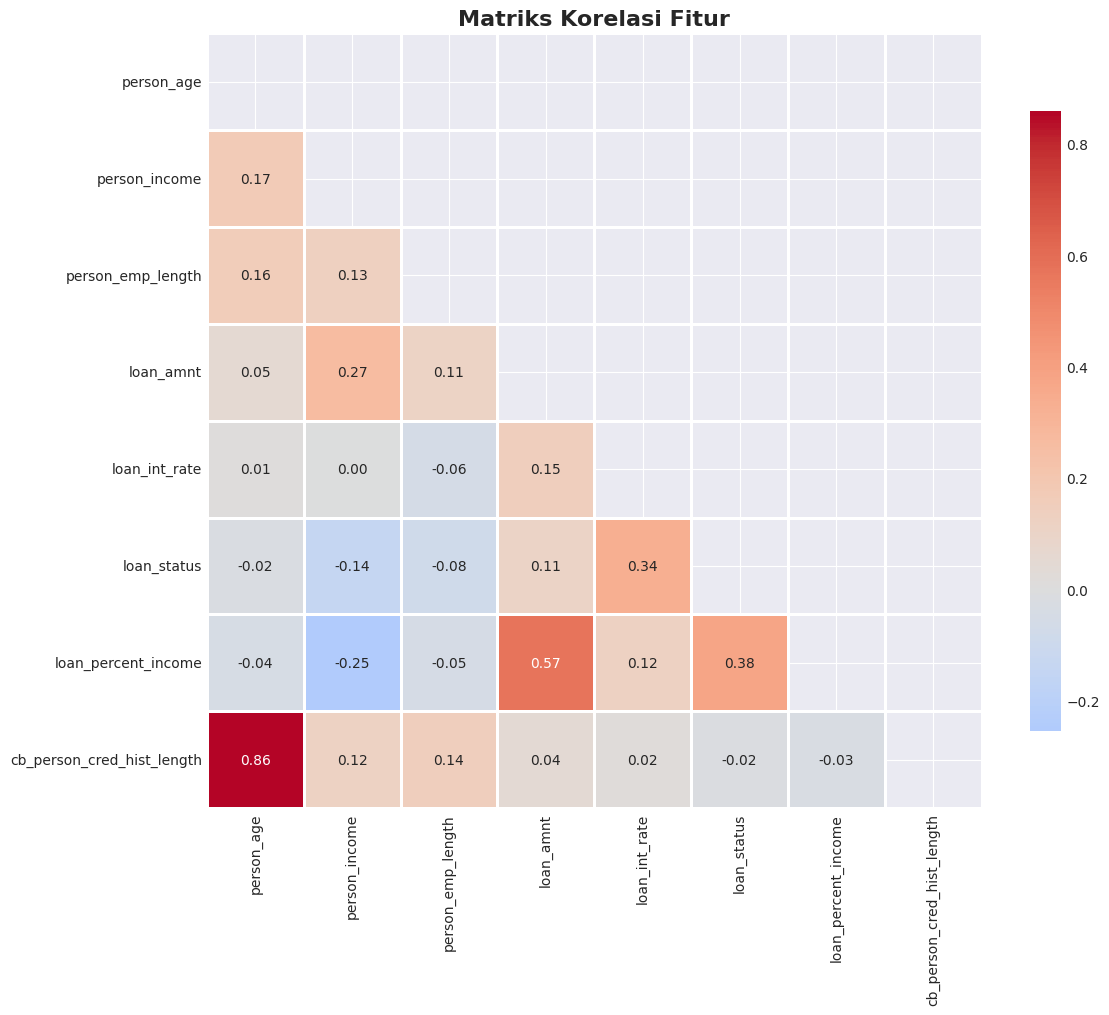

In [13]:
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Matriks Korelasi Fitur', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

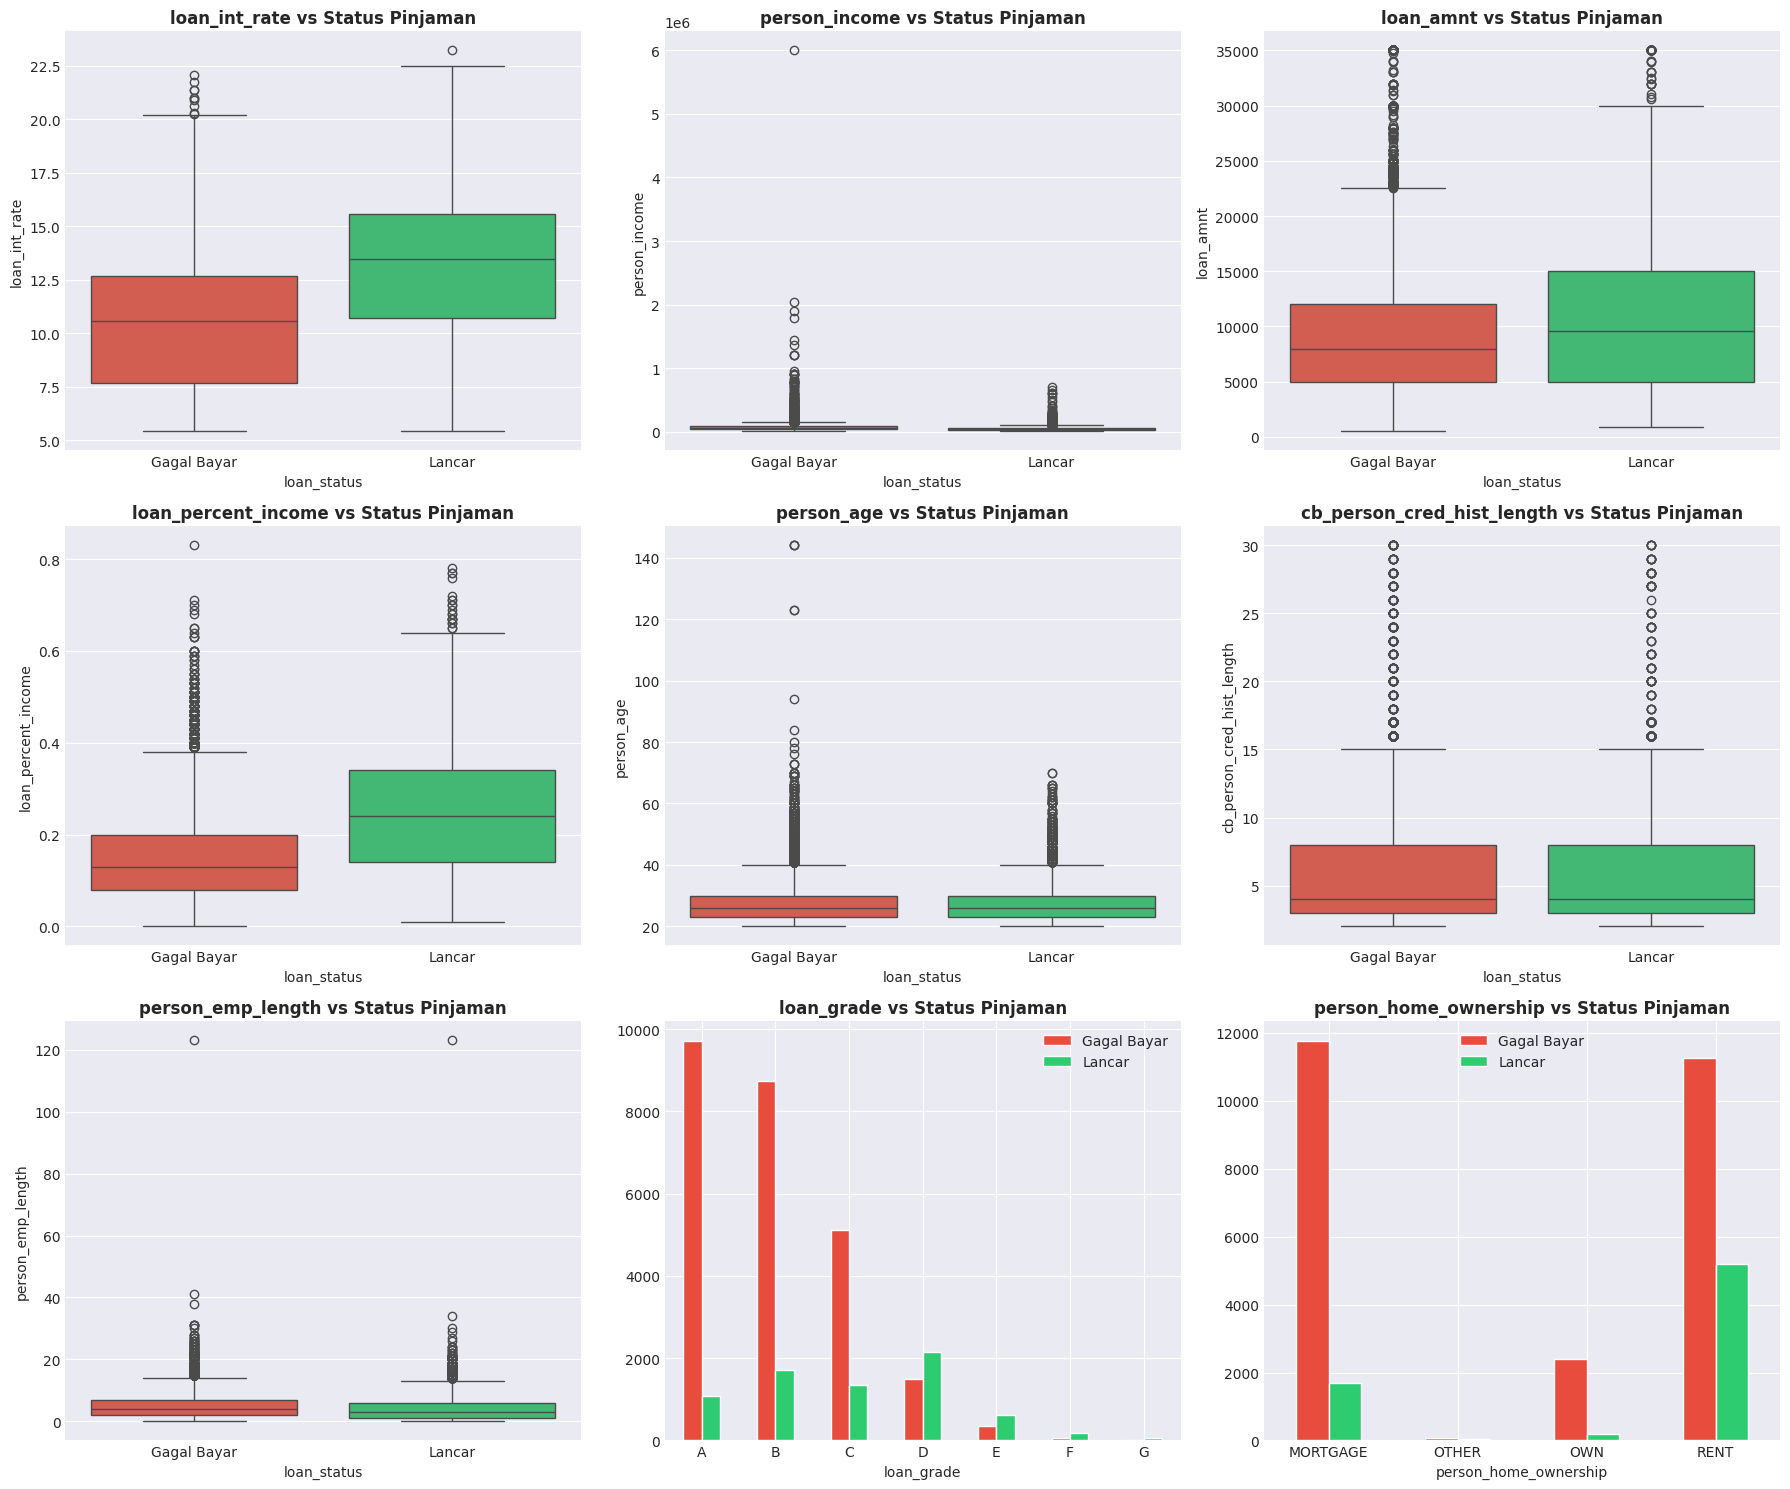

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

important_features = ['loan_int_rate', 'person_income', 'loan_amnt',
                     'loan_percent_income', 'person_age', 'cb_person_cred_hist_length',
                     'person_emp_length', 'loan_grade', 'person_home_ownership']

for idx, feature in enumerate(important_features):
    if idx < len(axes):
        if feature in numeric_cols:
            sns.boxplot(data=df, x='loan_status', y=feature, palette=['#e74c3c', '#2ecc71'], ax=axes[idx])
            axes[idx].set_xticklabels(['Gagal Bayar', 'Lancar'])
        else:
            pd.crosstab(df[feature], df['loan_status']).plot(kind='bar', ax=axes[idx],
                                                             color=['#e74c3c', '#2ecc71'])
            axes[idx].legend(['Gagal Bayar', 'Lancar'])

        axes[idx].set_title(f'{feature} vs Status Pinjaman', fontsize=12, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [15]:
df_processed = df.copy()

if df_processed['person_emp_length'].isnull().any():
    df_processed['person_emp_length'] = df_processed.groupby('loan_intent')['person_emp_length'].transform(
        lambda x: x.fillna(x.median() if not x.median() != x.median() else x.mean())
    )
    df_processed['person_emp_length'].fillna(df_processed['person_emp_length'].median(), inplace=True)

outlier_rules = {
    'person_age': {'min': 18, 'max': 100},
    'person_income': {'percentile': [1, 99.5]},
    'loan_percent_income': {'min': 0, 'max': 1},
    'person_emp_length': {'percentile': [0, 99]},
    'cb_person_cred_hist_length': {'percentile': [0, 99.5]}
}

In [16]:
df_clean = df_processed.copy()

for col, rules in outlier_rules.items():
    if 'min' in rules and 'max' in rules:
        df_clean[col] = df_clean[col].clip(lower=rules.get('min'), upper=rules.get('max'))
    elif 'percentile' in rules:
        lower = df_clean[col].quantile(rules['percentile'][0]/100)
        upper = df_clean[col].quantile(rules['percentile'][1]/100)
        df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)

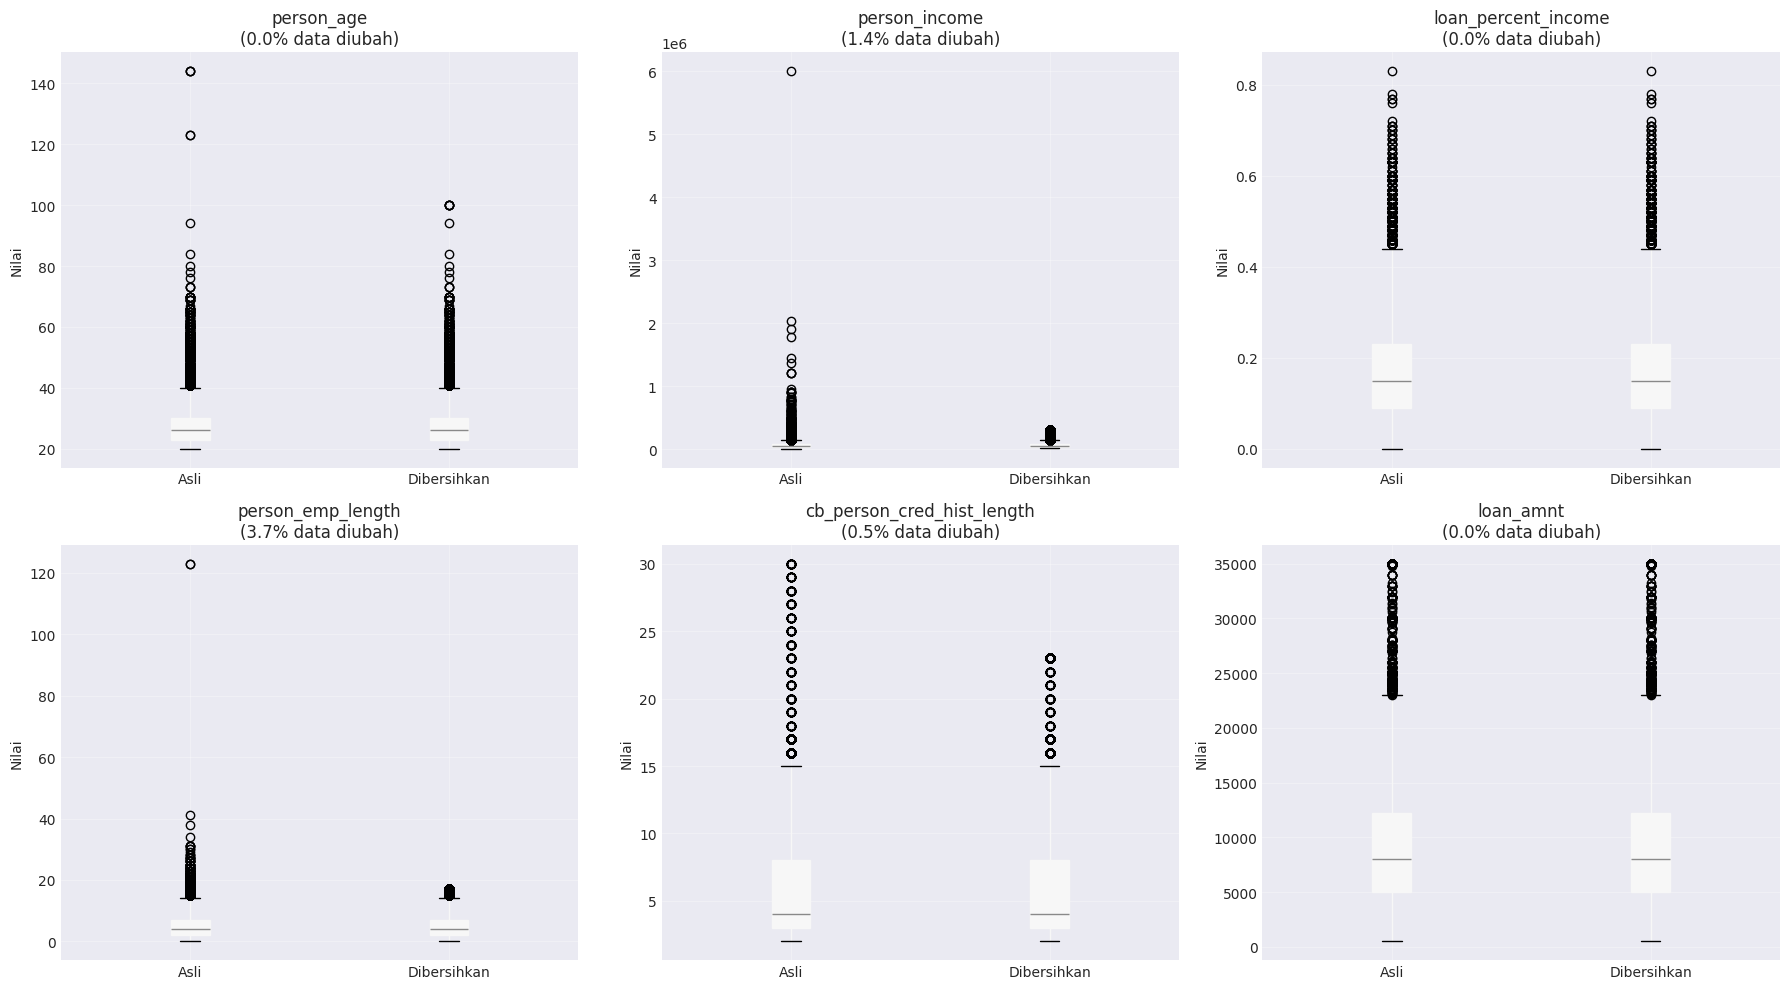

In [17]:
cols_to_plot = ['person_age', 'person_income', 'loan_percent_income',
                'person_emp_length', 'cb_person_cred_hist_length', 'loan_amnt']

plt.figure(figsize=(18, 10))

for idx, col in enumerate(cols_to_plot):
    plt.subplot(2, 3, idx + 1)

    data_comparison = pd.DataFrame({
        'Asli': df[col],
        'Dibersihkan': df_clean[col]
    })
    data_comparison.boxplot(patch_artist=True)

    changed_pct = ((df[col] != df_clean[col]).sum() / len(df)) * 100

    plt.title(f'{col}\n({changed_pct:.1f}% data diubah)', fontsize=12)
    plt.ylabel('Nilai')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
df_feat = df_clean.copy()

df_feat['debt_to_income_category'] = pd.cut(
    df_feat['loan_percent_income'],
    bins=[0, 0.1, 0.2, 0.3, 0.4, 1.0],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

df_feat['age_group'] = pd.cut(
    df_feat['person_age'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=['Gen Z', 'Millennial', 'Gen X', 'Boomer', 'Senior', 'Elder']
)

df_feat['income_category'] = pd.qcut(
    df_feat['person_income'],
    q=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    duplicates='drop'
)

df_feat['credit_history_category'] = pd.cut(
    df_feat['cb_person_cred_hist_length'],
    bins=[0, 2, 5, 10, 20, 100],
    labels=['New', 'Short', 'Medium', 'Long', 'Very Long']
)

df_feat['employment_stability'] = pd.cut(
    df_feat['person_emp_length'],
    bins=[0, 2, 5, 10, 100],
    labels=['Unstable', 'Stable', 'Very Stable', 'Highly Stable']
)

In [19]:
grade_risk = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_feat['grade_risk_score'] = df_feat['loan_grade'].map(grade_risk)

df_feat['combined_risk_score'] = (
    df_feat['loan_int_rate'] * df_feat['grade_risk_score'] / 10
)

df_feat['income_to_age_ratio'] = df_feat['person_income'] / (df_feat['person_age'] + 1)
df_feat['loan_to_income_ratio'] = df_feat['loan_amnt'] / (df_feat['person_income'] + 1)
df_feat['credit_utilization'] = (
    df_feat['loan_amnt'] / (df_feat['person_income'] * df_feat['cb_person_cred_hist_length'] + 1)
)

for col in ['person_income', 'loan_amnt']:
    df_feat[f'{col}_log'] = np.log1p(df_feat[col])

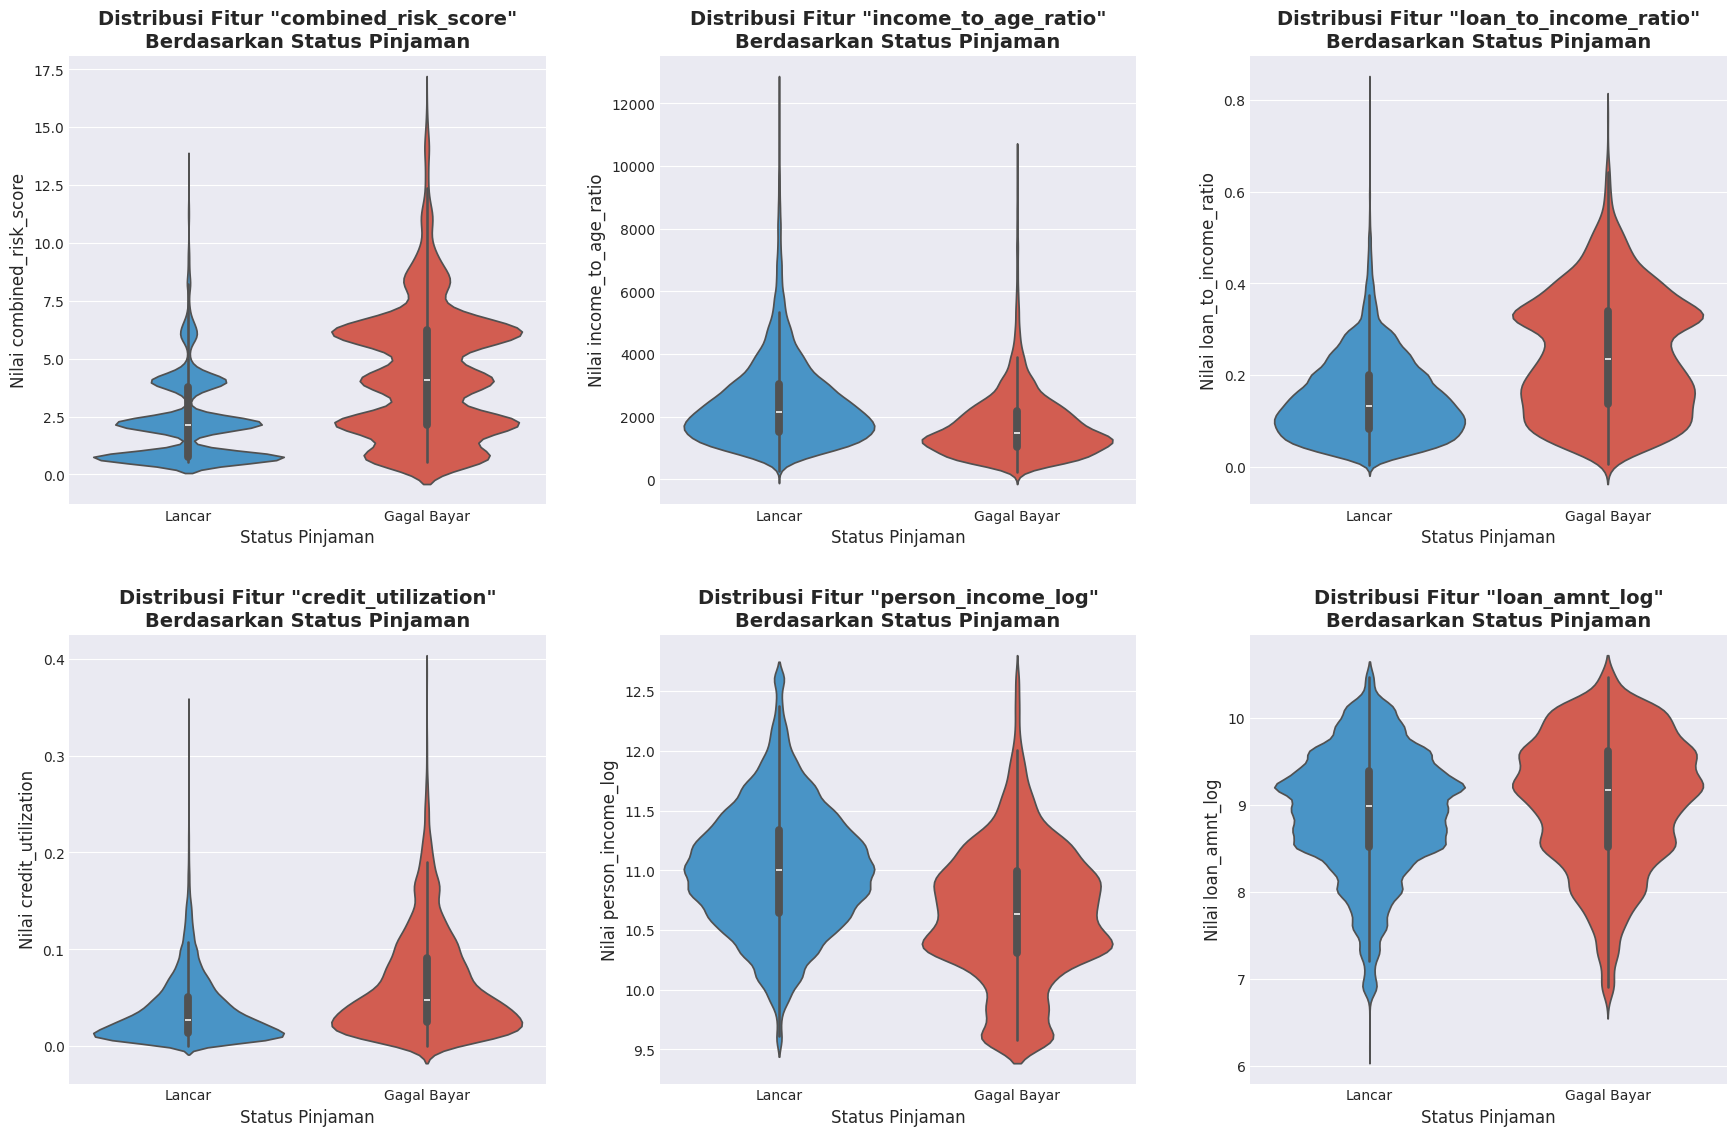

In [20]:
engineered_features = [
    'combined_risk_score', 'income_to_age_ratio', 'loan_to_income_ratio',
    'credit_utilization', 'person_income_log', 'loan_amnt_log'
]

sns.set_style("darkgrid")
plt.figure(figsize=(18, 12))

for idx, feature in enumerate(engineered_features):
    plt.subplot(2, 3, idx + 1)

    sns.violinplot(
        data=df_feat,
        x='loan_status',
        y=feature,
        palette=['#3498db', '#e74c3c']
    )

    plt.title(f'Distribusi Fitur "{feature}"\nBerdasarkan Status Pinjaman', fontsize=14, fontweight='bold')
    plt.xlabel('Status Pinjaman', fontsize=12)
    plt.ylabel(f'Nilai {feature}', fontsize=12)
    plt.xticks([0, 1], ['Lancar', 'Gagal Bayar'])

plt.tight_layout(pad=3.0)
plt.show()

In [21]:
df_encoded = df_feat.copy()

ordinal_mappings = {
    'loan_grade': {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1},
    'employment_stability': {'Unstable': 1, 'Stable': 2, 'Very Stable': 3, 'Highly Stable': 4},
    'debt_to_income_category': {'Very Low': 1, 'Low': 2, 'Medium': 3, 'High': 4, 'Very High': 5},
    'income_category': {'Very Low': 1, 'Low': 2, 'Medium': 3, 'High': 4, 'Very High': 5},
    'credit_history_category': {'New': 1, 'Short': 2, 'Medium': 3, 'Long': 4, 'Very Long': 5}
}

encoding_mappings = {}
for col, mapping in ordinal_mappings.items():
    if col in df_encoded.columns:
        df_encoded[f'{col}_encoded'] = df_encoded[col].map(mapping)
        encoding_mappings[col] = mapping

target_encoding = df_encoded.groupby('loan_intent')['loan_status'].agg(['mean', 'count'])
global_mean = df_encoded['loan_status'].mean()
smoothing_factor = 10
target_encoding['smoothed_mean'] = (
    (target_encoding['mean'] * target_encoding['count'] + global_mean * smoothing_factor) /
    (target_encoding['count'] + smoothing_factor)
)

df_encoded = df_encoded.merge(
    target_encoding[['smoothed_mean']],
    left_on='loan_intent',
    right_index=True,
    how='left'
)
df_encoded.rename(columns={'smoothed_mean': 'loan_intent_target_encoded'}, inplace=True)

categorical_cols = ['person_home_ownership', 'cb_person_default_on_file', 'age_group']
df_encoded = pd.get_dummies(
    df_encoded,
    columns=categorical_cols,
    prefix=categorical_cols,
    drop_first=True
)

In [22]:
cols_to_drop = ['loan_grade', 'loan_intent', 'debt_to_income_category',
                'income_category', 'credit_history_category', 'employment_stability']

cols_to_drop = [col for col in cols_to_drop if col in df_encoded.columns]
df_encoded.drop(cols_to_drop, axis=1, inplace=True)

feature_names = [col for col in df_encoded.columns if col != 'loan_status']

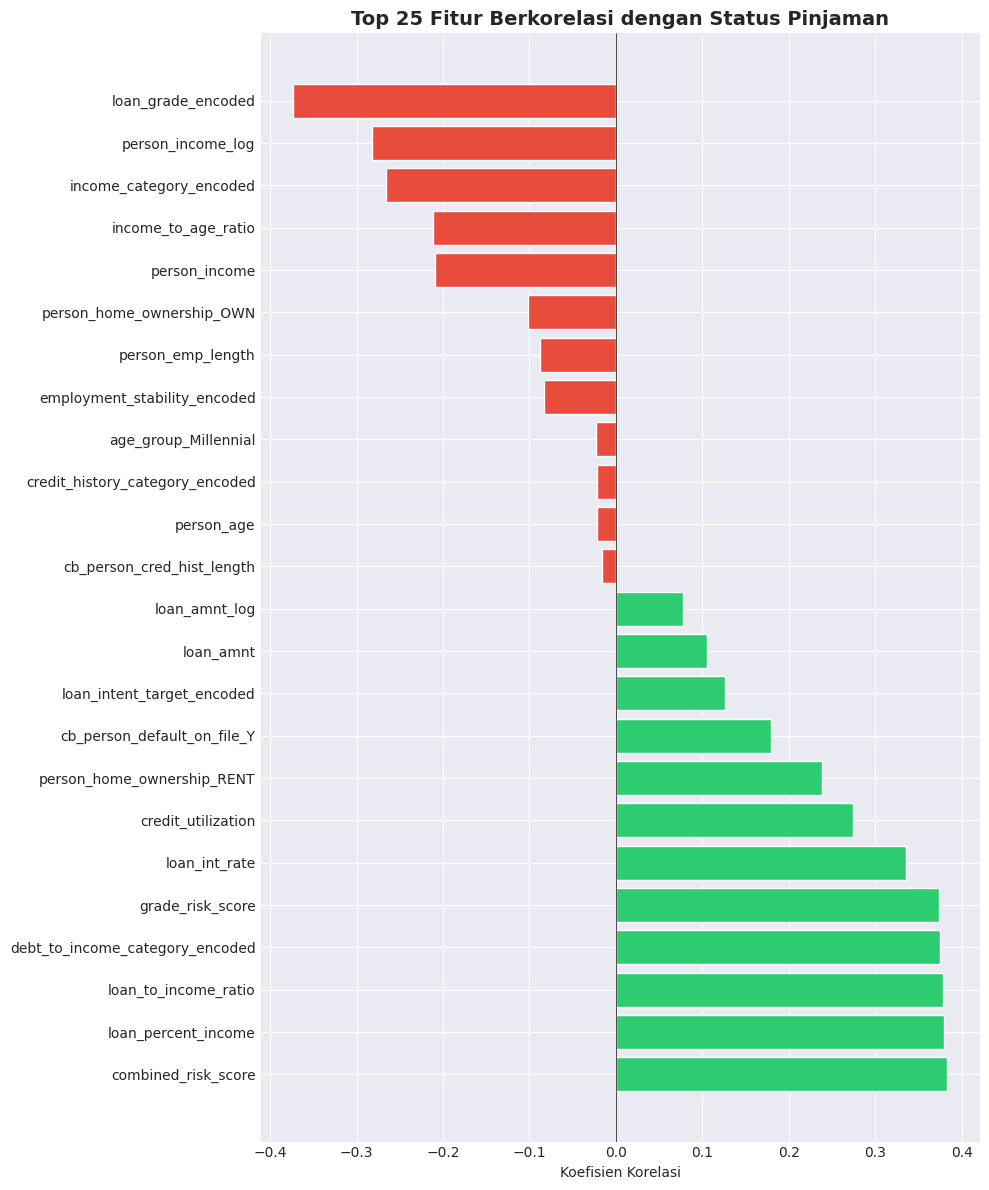

In [23]:
correlations = df_encoded.corr()['loan_status'].sort_values(ascending=False)
correlations = correlations[correlations.index != 'loan_status']

plt.figure(figsize=(10, 12))
top_n = 25
top_correlations = pd.concat([correlations.head(top_n//2), correlations.tail(top_n//2)])
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_correlations.values]

plt.barh(top_correlations.index, top_correlations.values, color=colors)
plt.title('Top 25 Fitur Berkorelasi dengan Status Pinjaman', fontsize=14, fontweight='bold')
plt.xlabel('Koefisien Korelasi')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [24]:
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

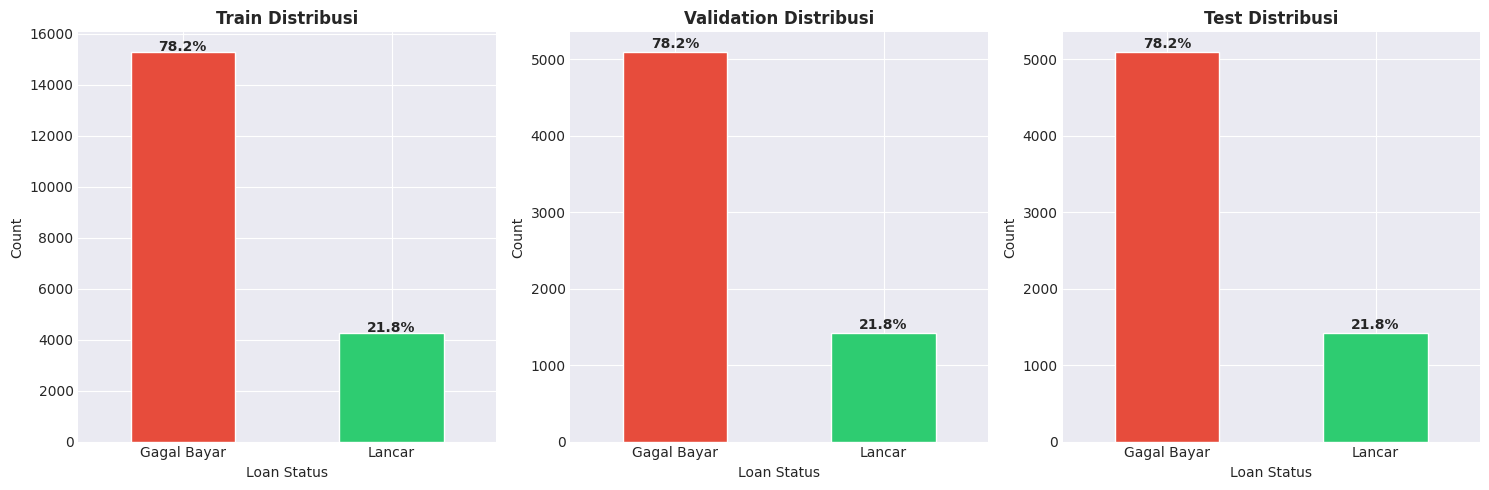

In [25]:
plt.figure(figsize=(15, 5))
splits = {'Train': y_train, 'Validation': y_val, 'Test': y_test}

for idx, (name, data) in enumerate(splits.items()):
    plt.subplot(1, 3, idx + 1)
    data.value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'])
    plt.title(f'{name} Distribusi', fontsize=12, fontweight='bold')
    plt.xlabel('Loan Status')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Gagal Bayar', 'Lancar'], rotation=0)

    for i, v in enumerate(data.value_counts().values):
        plt.text(i, v + 50, f'{v/len(data)*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [26]:
scaler = RobustScaler()
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imputed)

X_val_imputed = imputer.transform(X_val)
X_val_scaled = scaler.transform(X_val_imputed)

X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

In [27]:
try:
    sampler = ADASYN(random_state=42, n_neighbors=5)
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_scaled, y_train)
except:
    X_train_balanced, y_train_balanced = X_train_scaled, y_train

print(f"Bentuk data asli: {X_train_scaled.shape}")
print(f"Bentuk data setelah ADASYN: {X_train_balanced.shape}")

Bentuk data asli: (19548, 29)
Bentuk data setelah ADASYN: (30059, 29)


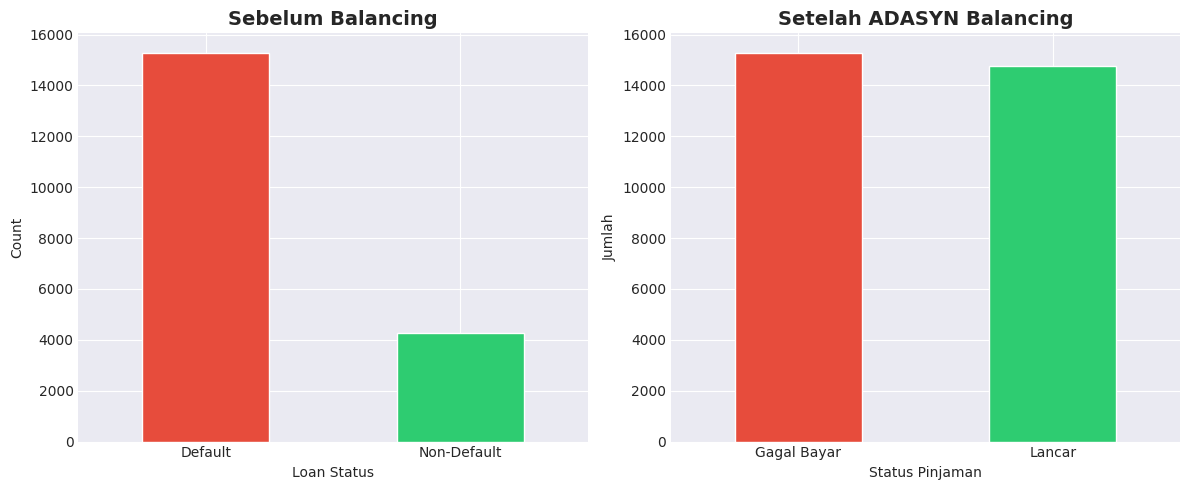

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'])
plt.title('Sebelum Balancing', fontsize=14, fontweight='bold')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Default', 'Non-Default'], rotation=0)

plt.subplot(1, 2, 2)
pd.Series(y_train_balanced).value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'])
plt.title('Setelah ADASYN Balancing', fontsize=14, fontweight='bold')
plt.xlabel('Status Pinjaman')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Gagal Bayar', 'Lancar'], rotation=0)

plt.tight_layout()
plt.show()

In [29]:
def create_sequences_3d(X, sequence_length=1):
    n_samples, n_features = X.shape
    X_seq = X.reshape((n_samples, sequence_length, n_features))
    return X_seq

sequence_length = 1
X_train_lstm = create_sequences_3d(X_train_scaled, sequence_length)
X_val_lstm = create_sequences_3d(X_val_scaled, sequence_length)
X_test_lstm = create_sequences_3d(X_test_scaled, sequence_length)

X_train_lstm = X_train_lstm.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val_lstm = X_val_lstm.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test_lstm = X_test_lstm.astype(np.float32)
y_test = y_test.astype(np.float32)

In [30]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = tf.pow((1 - p_t), gamma)
        cross_entropy = -tf.math.log(p_t)

        loss = alpha_t * focal_term * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)
        y_pred_binary = (y_pred > 0.5).astype(int)

        f1 = f1_score(y_val, y_pred_binary)

        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_binary).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        balanced_acc = (sensitivity + specificity) / 2

        logs['val_f1'] = f1
        logs['val_balanced_acc'] = balanced_acc

        if (epoch + 1) % 10 == 0:
            print(f" — val_f1: {f1:.4f}, val_balanced_acc: {balanced_acc:.4f}")

In [31]:
def create_improved_lstm_model(input_shape, learning_rate=0.001):
    model = Sequential([
        Input(shape=input_shape),
        GaussianNoise(0.01),
        LSTM(32, return_sequences=False,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             dropout=0.2,
             recurrent_dropout=0.2),
        BatchNormalization(),
        Dense(16, activation='relu',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

In [32]:
lstm_model_improved = create_improved_lstm_model(
    input_shape=(sequence_length, X_train_lstm.shape[2]),
    learning_rate=0.001
)

lstm_model_improved.summary()

class_weight_values = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weight_values))
print(f"\nClass weights yang dihitung: {class_weight_dict}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 1, 29)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,737 (34.13 KB)

 Trainable params: 8,673 (33.88 KB)

 Non-trainable params: 64 (256.00 B)


Class weights yang dihitung: {0: np.float64(0.6395341228816331), 1: np.float64(2.2916764361078545)}


In [33]:
f1_callback = F1ScoreCallback(validation_data=(X_val_lstm, y_val))

callbacks_improved = [
    EarlyStopping(
        monitor='val_auc',
        patience=25,
        restore_best_weights=True,
        verbose=1,
        mode='max',
        min_delta=0.0005
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_lstm_model_improved.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    f1_callback
]

In [34]:
history_improved = lstm_model_improved.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=150,
    batch_size=128,
    callbacks=callbacks_improved,
    class_weight=class_weight_dict,
    verbose=1,
    shuffle=True
)

Epoch 1/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6582 - auc: 0.7094 - loss: 0.6628 - precision: 0.3485 - recall: 0.6523
Epoch 1: val_auc improved from -inf to 0.86299, saving model to best_lstm_model_improved.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.6583 - auc: 0.7097 - loss: 0.6624 - precision: 0.3486 - recall: 0.6527 - val_accuracy: 0.8582 - val_auc: 0.8630 - val_loss: 0.6200 - val_precision: 0.7182 - val_recall: 0.5757 - learning_rate: 0.0010 - val_f1: 0.6391 - val_balanced_acc: 0.7563
Epoch 2/150
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7431 - auc: 0.8298 - loss: 0.5220 - precision: 0.4489 - recall: 0.7660
Epoch 2: val_auc improved from 0.86299 to 0.87938, saving model to best_lstm_model_improved.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7433 - auc: 0.8298 - loss: 0.5219 - precision: 0.4490 - recall: 0.7659 - val_accuracy: 0.8619 - val_auc: 0.8794 - val_loss: 0.5223 - val_precision: 0.6857 - val_recall: 0.6

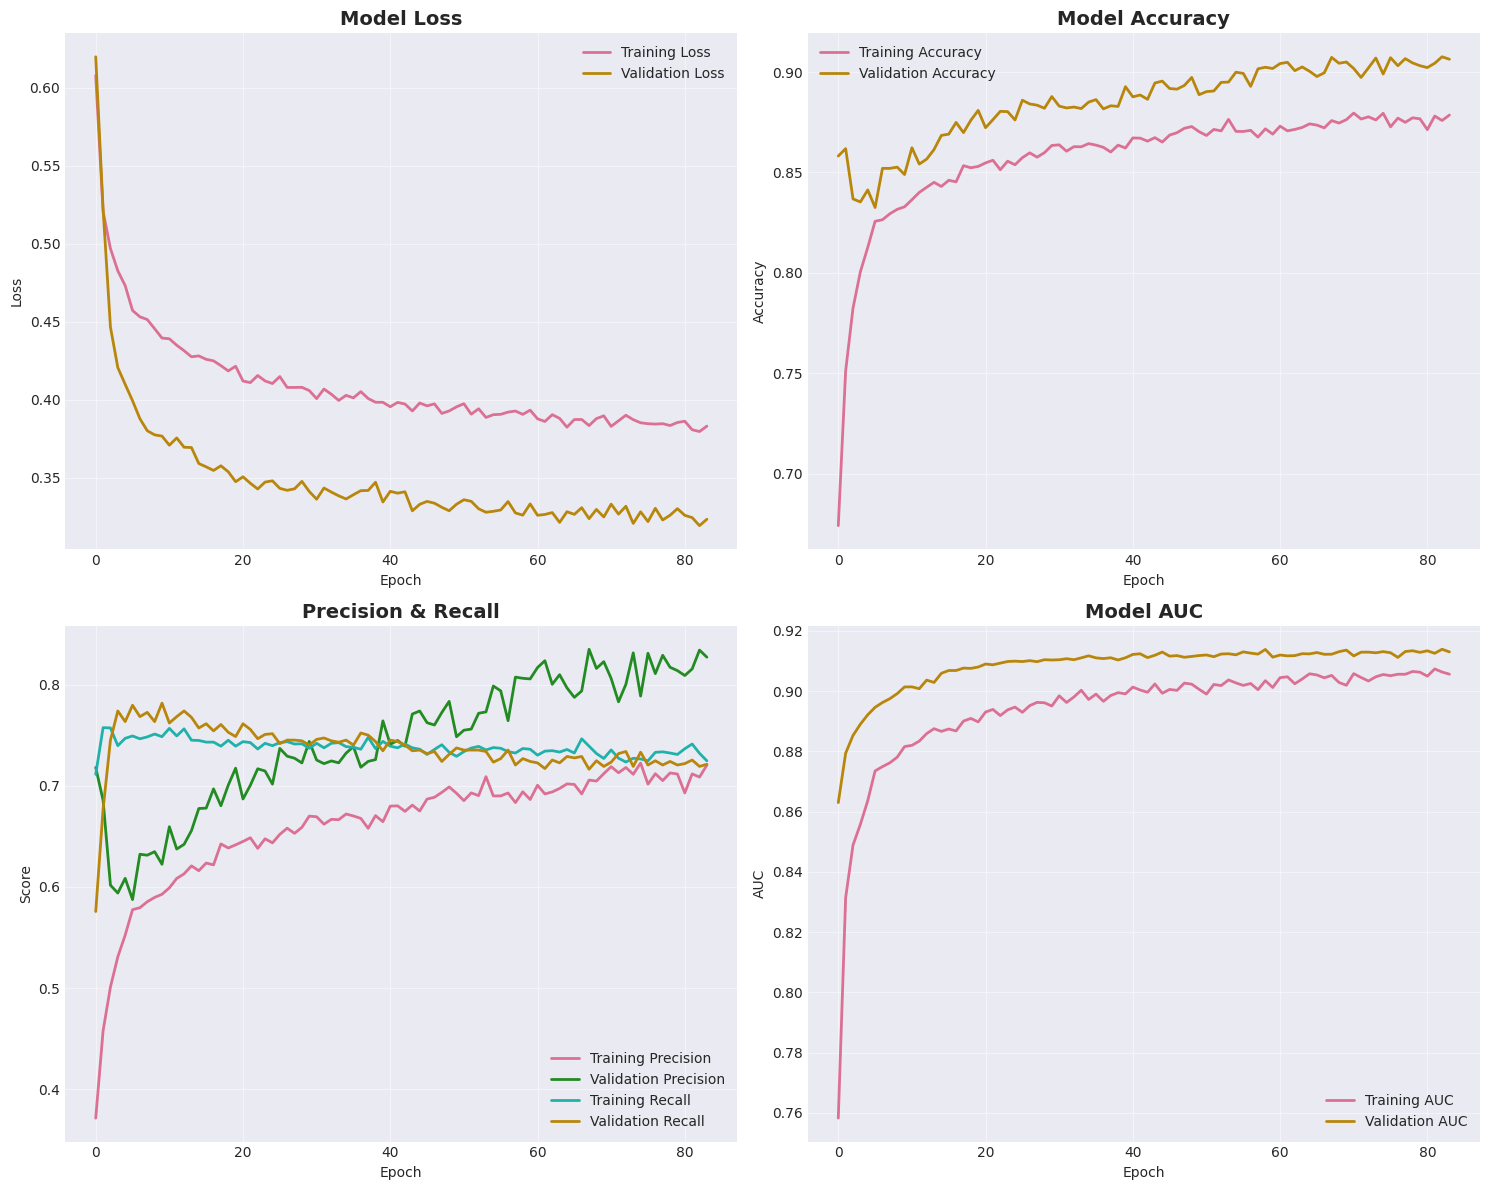

In [35]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.plot(history_improved.history['loss'], label='Training Loss', linewidth=2, color='palevioletred')
plt.plot(history_improved.history['val_loss'], label='Validation Loss', linewidth=2, color='darkgoldenrod')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(2, 2, 2)
plt.plot(history_improved.history['accuracy'], label='Training Accuracy', linewidth=2, color='palevioletred')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='darkgoldenrod')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(2, 2, 3)
plt.plot(history_improved.history['precision'], label='Training Precision', linewidth=2, color='palevioletred')
plt.plot(history_improved.history['val_precision'], label='Validation Precision', linewidth=2, color='forestgreen')
plt.plot(history_improved.history['recall'], label='Training Recall', linewidth=2, color='lightseagreen')
plt.plot(history_improved.history['val_recall'], label='Validation Recall', linewidth=2, color='darkgoldenrod')
plt.title('Precision & Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(2, 2, 4)
plt.plot(history_improved.history['auc'], label='Training AUC', linewidth=2, color='palevioletred')
plt.plot(history_improved.history['val_auc'], label='Validation AUC', linewidth=2, color='darkgoldenrod')
plt.title('Model AUC', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

In [36]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    eval_metric='logloss'
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    verbosity=-1
)

cat_model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    random_state=42,
    verbose=False
)

In [37]:
xgb_model.set_params(early_stopping_rounds=20)
xgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

lgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
)

cat_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=(X_val_scaled, y_val),
    early_stopping_rounds=20,
    verbose=False
)

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.193345


In [38]:
val_predictions = {
    'xgboost': xgb_model.predict_proba(X_val_scaled)[:, 1],
    'lightgbm': lgb_model.predict_proba(X_val_scaled)[:, 1],
    'catboost': cat_model.predict_proba(X_val_scaled)[:, 1]
}

def ensemble_loss(weights, predictions, y_true):
    weighted_pred = sum(w * predictions[name]
                       for w, name in zip(weights, predictions.keys()))
    return -roc_auc_score(y_true, weighted_pred)

initial_weights = [1/3, 1/3, 1/3]
constraints = {'type': 'eq', 'fun': lambda w: sum(w) - 1}
bounds = [(0, 1), (0, 1), (0, 1)]

result = minimize(
    lambda w: ensemble_loss(w, val_predictions, y_val),
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

ensemble_weights = dict(zip(val_predictions.keys(), result.x))

In [39]:
def get_ensemble_predictions(X, models, weights):
    predictions = np.zeros((len(X), 2))
    predictions += weights['xgboost'] * models['xgboost'].predict_proba(X)
    predictions += weights['lightgbm'] * models['lightgbm'].predict_proba(X)
    predictions += weights['catboost'] * models['catboost'].predict_proba(X)
    return predictions

ensemble_models = {'xgboost': xgb_model, 'lightgbm': lgb_model, 'catboost': cat_model}
y_pred_proba_ensemble_val = get_ensemble_predictions(X_val_scaled, ensemble_models, ensemble_weights)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba_ensemble_val)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

In [40]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'average_precision': average_precision_score(y_true, y_pred_proba)
    }

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Lancar', 'Gagal Bayar'],
                yticklabels=['Lancar', 'Gagal Bayar'],
                cbar_kws={'label': 'Jumlah'})

    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / cm.sum() * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                    ha='center', va='center', fontsize=10, color='gray')

    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Label Sebenarnya')
    plt.xlabel('Label Prediksi')
    plt.tight_layout()
    plt.show()

    return metrics, cm

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


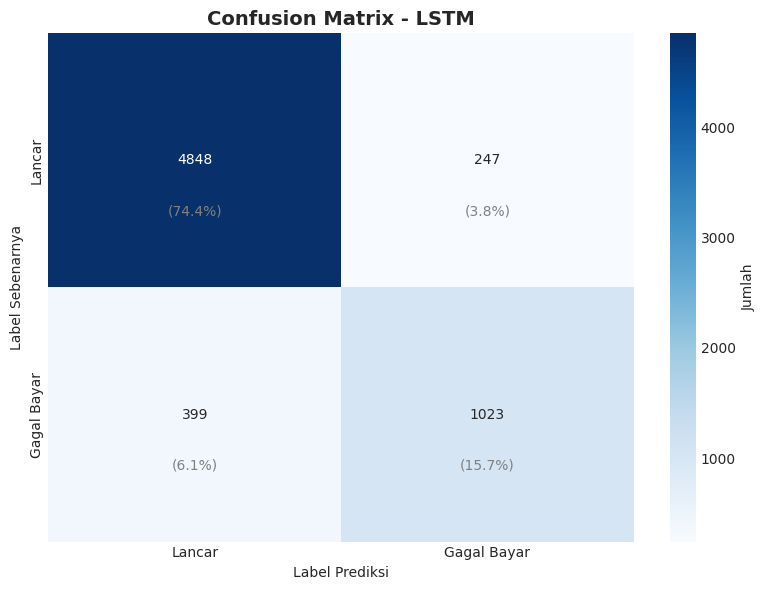

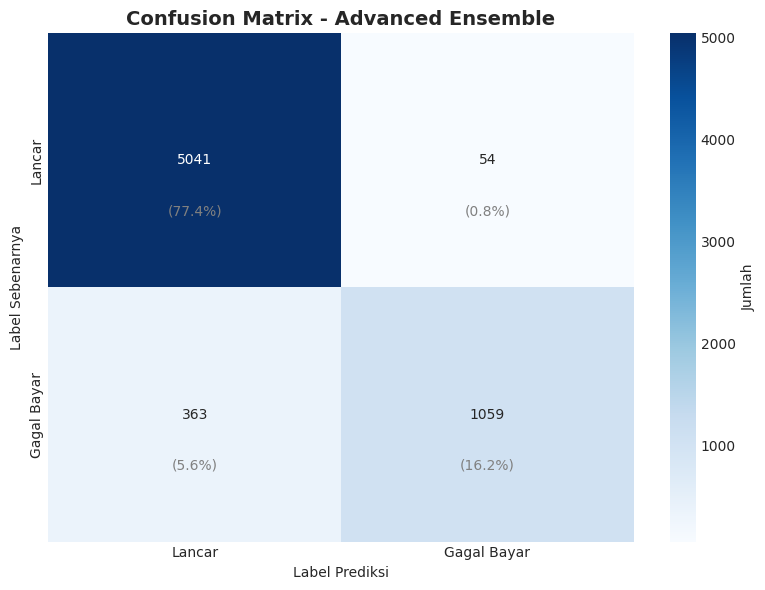

In [41]:
y_pred_lstm_proba = lstm_model_improved.predict(X_test_lstm)
y_pred_lstm_proba = np.clip(y_pred_lstm_proba.flatten(), 0, 1)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

y_pred_ensemble_proba = get_ensemble_predictions(X_test_scaled, ensemble_models, ensemble_weights)[:, 1]
y_pred_ensemble = (y_pred_ensemble_proba >= optimal_threshold).astype(int)

lstm_metrics, lstm_cm = evaluate_model(y_test, y_pred_lstm, y_pred_lstm_proba, "LSTM")
ensemble_metrics, ensemble_cm = evaluate_model(y_test, y_pred_ensemble, y_pred_ensemble_proba, "Advanced Ensemble")

In [42]:
data_untuk_df = {
    'Model': ['LSTM', 'Ensemble'],
    'accuracy': [lstm_metrics['accuracy'], ensemble_metrics['accuracy']],
    'precision': [lstm_metrics['precision'], ensemble_metrics['precision']],
    'recall': [lstm_metrics['recall'], ensemble_metrics['recall']],
    'f1_score': [lstm_metrics['f1_score'], ensemble_metrics['f1_score']],
    'roc_auc': [lstm_metrics['roc_auc'], ensemble_metrics['roc_auc']]
}
comparison_df = pd.DataFrame(data_untuk_df)
comparison_df = comparison_df.set_index('Model')
comparison_df.head()

,accuracy,precision,recall,f1_score,roc_auc
Model,,,,,
LSTM,0.901,0.806,0.719,0.760,0.916
Ensemble,0.936,0.951,0.745,0.836,0.948


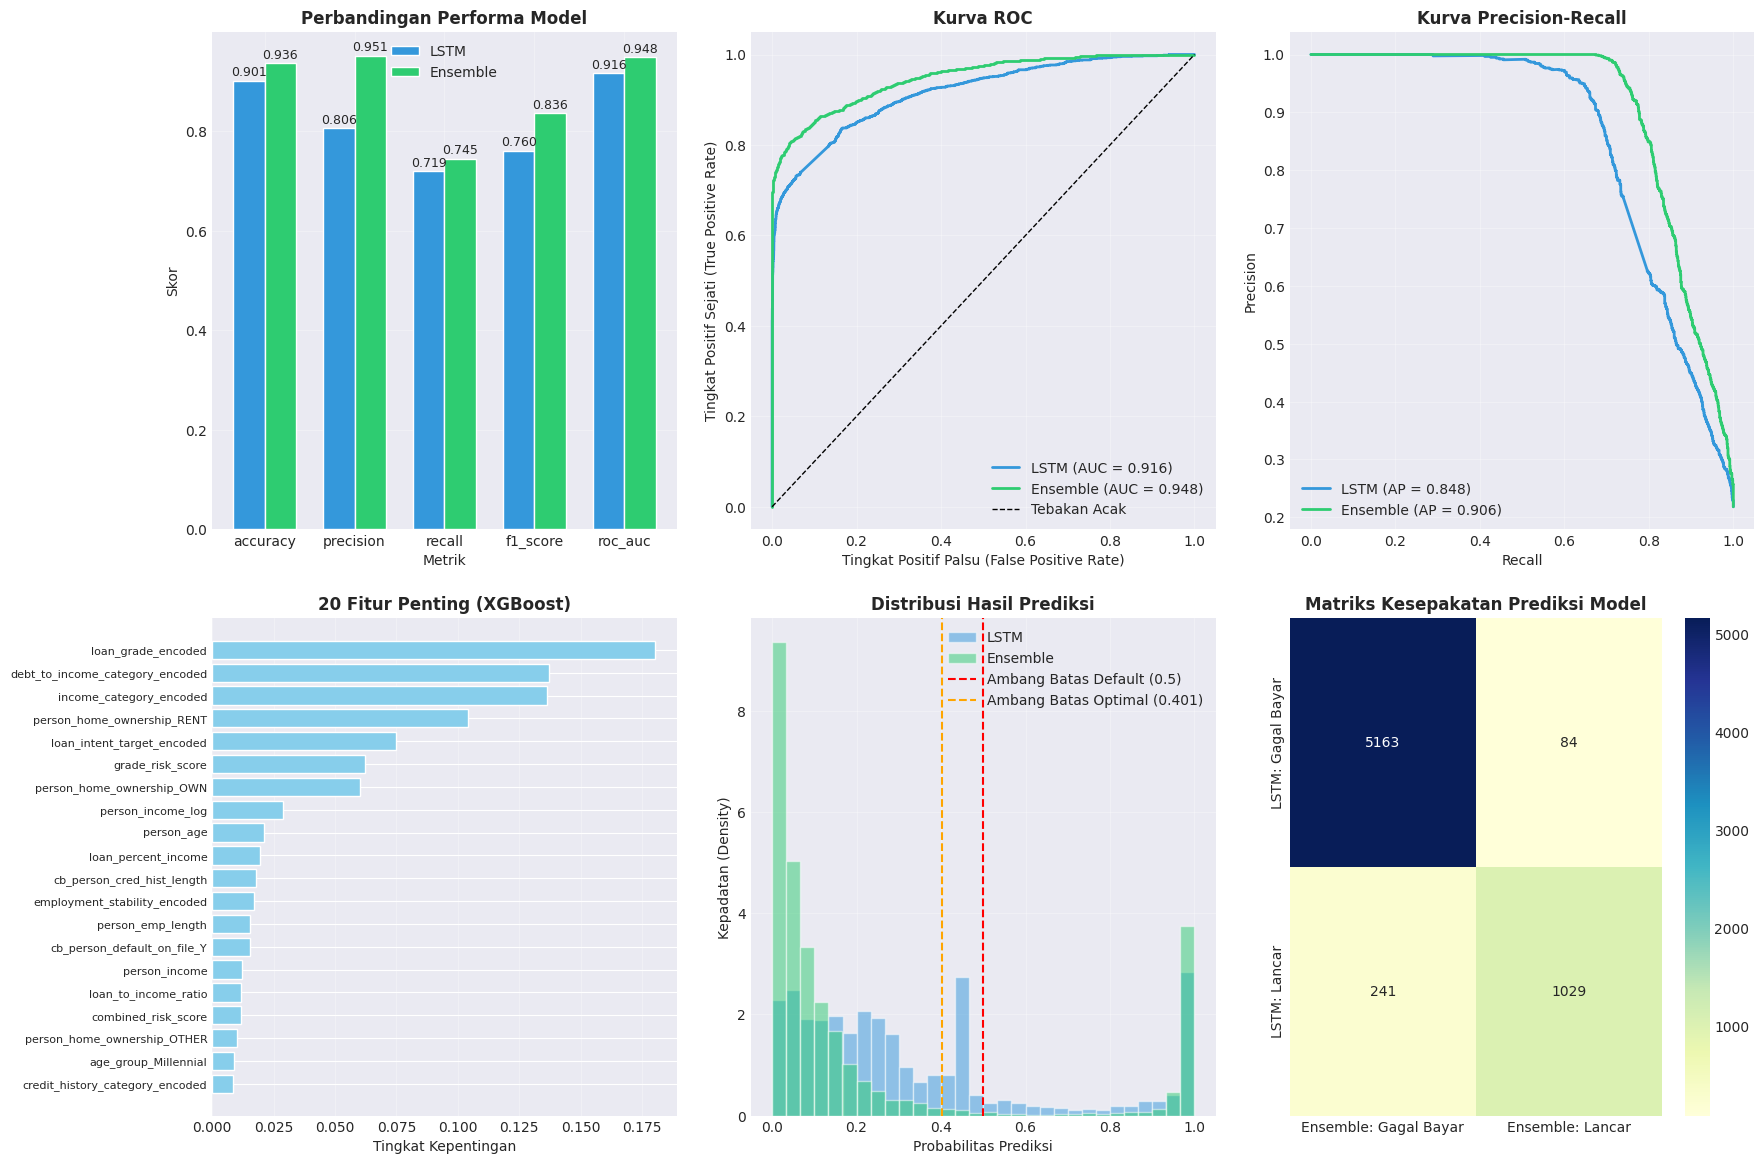

In [43]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
models = ['LSTM', 'Ensemble']
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x = np.arange(len(metrics))
width = 0.35

lstm_values = [lstm_metrics[m] for m in metrics]
ensemble_values = [ensemble_metrics[m] for m in metrics]

plt.bar(x - width/2, lstm_values, width, label='LSTM', color='#3498db')
plt.bar(x + width/2, ensemble_values, width, label='Ensemble', color='#2ecc71')

plt.xlabel('Metrik')
plt.ylabel('Skor')
plt.title('Perbandingan Performa Model', fontweight='bold')
plt.xticks(x, metrics, rotation=0)
plt.legend()
plt.grid(True, alpha=0.3)

for i, (lstm_val, ens_val) in enumerate(zip(lstm_values, ensemble_values)):
    plt.text(i - width/2, lstm_val + 0.01, f'{lstm_val:.3f}', ha='center', fontsize=9)
    plt.text(i + width/2, ens_val + 0.01, f'{ens_val:.3f}', ha='center', fontsize=9)

plt.subplot(2, 3, 2)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm_proba)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_ensemble_proba)

plt.plot(fpr_lstm, tpr_lstm, linewidth=2, label=f'LSTM (AUC = {lstm_metrics["roc_auc"]:.3f})', color='#3498db')
plt.plot(fpr_ensemble, tpr_ensemble, linewidth=2, label=f'Ensemble (AUC = {ensemble_metrics["roc_auc"]:.3f})', color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Tebakan Acak')

plt.xlabel('Tingkat Positif Palsu (False Positive Rate)')
plt.ylabel('Tingkat Positif Sejati (True Positive Rate)')
plt.title('Kurva ROC', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
precision_lstm, recall_lstm, _ = precision_recall_curve(y_test, y_pred_lstm_proba)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, y_pred_ensemble_proba)

plt.plot(recall_lstm, precision_lstm, linewidth=2,
         label=f'LSTM (AP = {lstm_metrics.get("average_precision", 0):.3f})', color='#3498db')
plt.plot(recall_ensemble, precision_ensemble, linewidth=2,
         label=f'Ensemble (AP = {ensemble_metrics.get("average_precision", 0):.3f})', color='#2ecc71')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Kurva Precision-Recall', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
importance = xgb_model.feature_importances_
indices = np.argsort(importance)[-20:]

plt.barh(range(len(indices)), importance[indices], color='skyblue')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=8)
plt.xlabel('Tingkat Kepentingan')
plt.title('20 Fitur Penting (XGBoost)', fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

plt.subplot(2, 3, 5)
plt.hist(y_pred_lstm_proba, bins=30, alpha=0.5, label='LSTM', color='#3498db', density=True)
plt.hist(y_pred_ensemble_proba, bins=30, alpha=0.5, label='Ensemble', color='#2ecc71', density=True)
plt.axvline(0.5, color='red', linestyle='--', label='Ambang Batas Default (0.5)')
plt.axvline(optimal_threshold, color='orange', linestyle='--', label=f'Ambang Batas Optimal ({optimal_threshold:.3f})')
plt.xlabel('Probabilitas Prediksi')
plt.ylabel('Kepadatan (Density)')
plt.title('Distribusi Hasil Prediksi', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
agreement_matrix = confusion_matrix(y_pred_lstm, y_pred_ensemble)
sns.heatmap(agreement_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Ensemble: Gagal Bayar', 'Ensemble: Lancar'],
            yticklabels=['LSTM: Gagal Bayar', 'LSTM: Lancar'])
plt.title('Matriks Kesepakatan Prediksi Model', fontweight='bold')

plt.tight_layout(pad=2.0)
plt.show()

In [44]:
cost_matrix = {
    'false_negative': 1000,
    'false_positive': 200
}

def calculate_business_impact(y_true, y_pred, y_pred_proba, cost_matrix):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cost_fn = fn * cost_matrix['false_negative']
    cost_fp = fp * cost_matrix['false_positive']
    total_cost = cost_fn + cost_fp

    return {
        'total_cost': total_cost,
        'cost_per_prediction': total_cost / len(y_true),
        'false_negative_cost': cost_fn,
        'false_positive_cost': cost_fp,
        'approval_rate': (tp + fp) / len(y_true),
        'default_capture_rate': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0
    }

lstm_business = calculate_business_impact(y_test, y_pred_lstm, y_pred_lstm_proba, cost_matrix)
ensemble_business = calculate_business_impact(y_test, y_pred_ensemble, y_pred_ensemble_proba, cost_matrix)

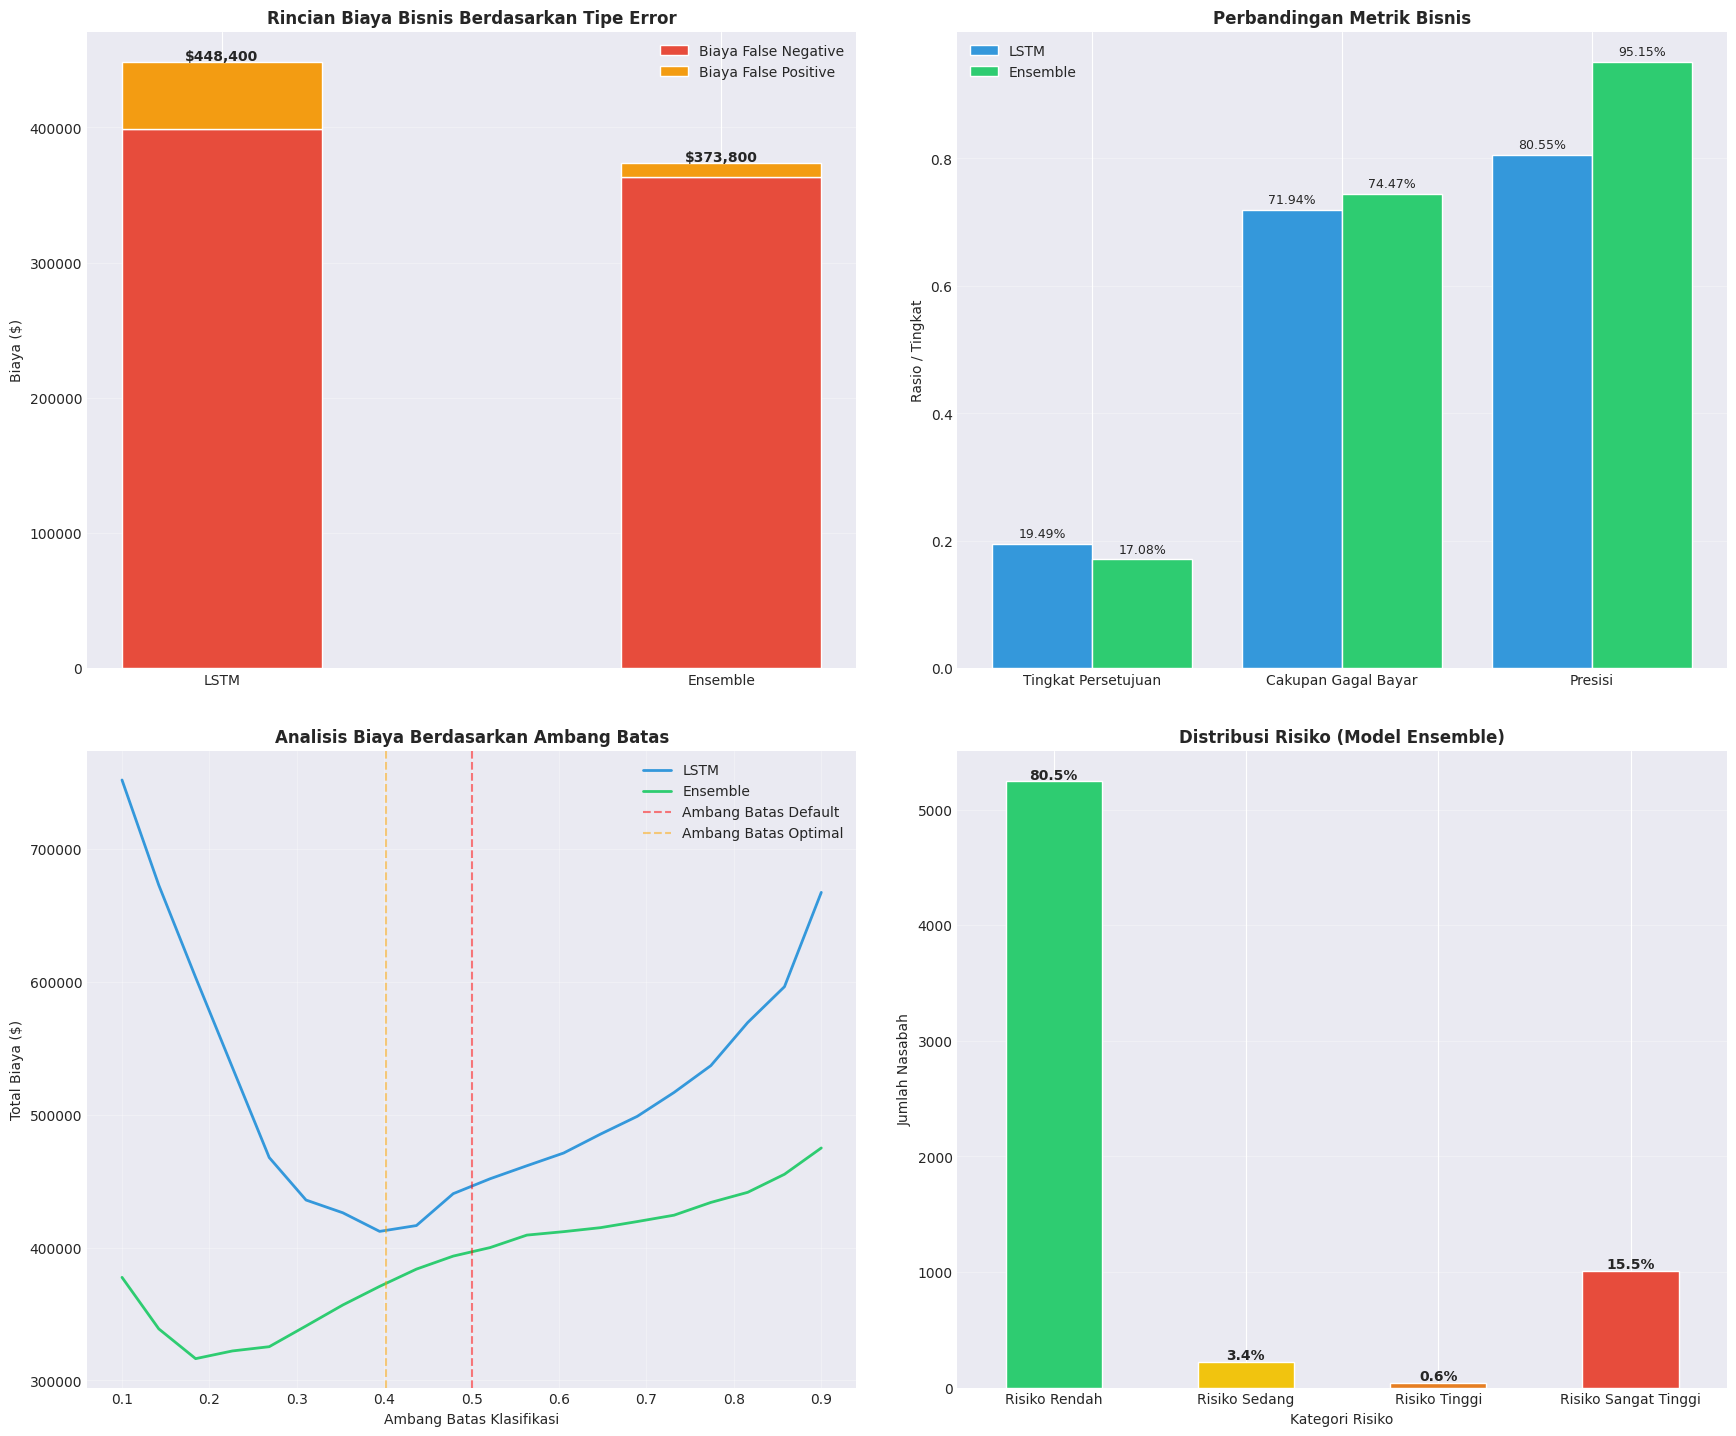

In [45]:
sns.set_style("darkgrid")
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
models = ['LSTM', 'Ensemble']
fn_costs = [lstm_business['false_negative_cost'], ensemble_business['false_negative_cost']]
fp_costs = [lstm_business['false_positive_cost'], ensemble_business['false_positive_cost']]

x = np.arange(len(models))
width = 0.4

plt.bar(x, fn_costs, width, label='Biaya False Negative', color='#e74c3c')
plt.bar(x, fp_costs, width, bottom=fn_costs, label='Biaya False Positive', color='#f39c12')

plt.ylabel('Biaya ($)')
plt.title('Rincian Biaya Bisnis Berdasarkan Tipe Error', fontweight='bold')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for i, (fn, fp) in enumerate(zip(fn_costs, fp_costs)):
    total = fn + fp
    plt.text(i, total + 1000, f'${total:,.0f}', ha='center', fontweight='bold')

plt.subplot(2, 2, 2)
metrics = ['approval_rate', 'default_capture_rate', 'precision']
lstm_values = [lstm_business[m] for m in metrics]
ensemble_values = [ensemble_business[m] for m in metrics]

x = np.arange(len(metrics))
plt.bar(x - width/2, lstm_values, width, label='LSTM', color='#3498db')
plt.bar(x + width/2, ensemble_values, width, label='Ensemble', color='#2ecc71')

plt.ylabel('Rasio / Tingkat')
plt.title('Perbandingan Metrik Bisnis', fontweight='bold')
plt.xticks(x, ['Tingkat Persetujuan', 'Cakupan Gagal Bayar', 'Presisi'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for i, (lstm_val, ens_val) in enumerate(zip(lstm_values, ensemble_values)):
    plt.text(i - width/2, lstm_val + 0.01, f'{lstm_val:.2%}', ha='center', fontsize=9)
    plt.text(i + width/2, ens_val + 0.01, f'{ens_val:.2%}', ha='center', fontsize=9)

plt.subplot(2, 2, 3)
thresholds = np.linspace(0.1, 0.9, 20)
costs_lstm = []
costs_ensemble = []

for thresh in thresholds:
    y_pred_lstm_thresh = (y_pred_lstm_proba > thresh).astype(int)
    y_pred_ensemble_thresh = (y_pred_ensemble_proba > thresh).astype(int)

    lstm_cost = calculate_business_impact(y_test, y_pred_lstm_thresh, y_pred_lstm_proba, cost_matrix)['total_cost']
    ensemble_cost = calculate_business_impact(y_test, y_pred_ensemble_thresh, y_pred_ensemble_proba, cost_matrix)['total_cost']

    costs_lstm.append(lstm_cost)
    costs_ensemble.append(ensemble_cost)

plt.plot(thresholds, costs_lstm, linewidth=2, label='LSTM', color='#3498db')
plt.plot(thresholds, costs_ensemble, linewidth=2, label='Ensemble', color='#2ecc71')
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Ambang Batas Default')
plt.axvline(optimal_threshold, color='orange', linestyle='--', alpha=0.5, label='Ambang Batas Optimal')

plt.xlabel('Ambang Batas Klasifikasi')
plt.ylabel('Total Biaya ($)')
plt.title('Analisis Biaya Berdasarkan Ambang Batas', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
risk_bins = [0, 0.3, 0.5, 0.7, 1.0]
risk_labels = ['Risiko Rendah', 'Risiko Sedang', 'Risiko Tinggi', 'Risiko Sangat Tinggi']

ensemble_risk_categories = pd.cut(y_pred_ensemble_proba, bins=risk_bins, labels=risk_labels, include_lowest=True)
risk_counts = ensemble_risk_categories.value_counts().sort_index()

colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
risk_counts.plot(kind='bar', color=colors)
plt.title('Distribusi Risiko (Model Ensemble)', fontweight='bold')
plt.xlabel('Kategori Risiko')
plt.ylabel('Jumlah Nasabah')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(risk_counts.values):
    plt.text(i, v + 20, f'{v/len(y_test)*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout(pad=3.0)
plt.show()

In [46]:
print("\nPerforma Model LSTM:")
print(f"  - Akurasi: {lstm_metrics['accuracy']:.4f}")
print(f"  - Presisi: {lstm_metrics['precision']:.4f}")
print(f"  - Recall: {lstm_metrics['recall']:.4f}")
print(f"  - F1 Score: {lstm_metrics['f1_score']:.4f}")
print(f"  - ROC AUC: {lstm_metrics['roc_auc']:.4f}")

print("\nPerforma Model Ensemble:")
print(f"  - Akurasi: {ensemble_metrics['accuracy']:.4f}")
print(f"  - Presisi: {ensemble_metrics['precision']:.4f}")
print(f"  - Recall: {ensemble_metrics['recall']:.4f}")
print(f"  - F1 Score: {ensemble_metrics['f1_score']:.4f}")
print(f"  - ROC AUC: {ensemble_metrics['roc_auc']:.4f}")

print("\nModel LSTM:")
print(f"  - Total Biaya Kesalahan: ${lstm_business['total_cost']:,.2f}")
print(f"  - Rata-rata Biaya per Prediksi: ${lstm_business['cost_per_prediction']:.2f}")
print(f"  - Tingkat Persetujuan Pinjaman: {lstm_business['approval_rate']:.2%}")
print(f"  - Tingkat Cakupan Gagal Bayar: {lstm_business['default_capture_rate']:.2%}")

print("\nModel Ensemble:")
print(f"  - Total Biaya Kesalahan: ${ensemble_business['total_cost']:,.2f}")
print(f"  - Rata-rata Biaya per Prediksi: ${ensemble_business['cost_per_prediction']:.2f}")
print(f"  - Tingkat Persetujuan Pinjaman: {ensemble_business['approval_rate']:.2%}")
print(f"  - Tingkat Cakupan Gagal Bayar: {ensemble_business['default_capture_rate']:.2%}")

penghematan_biaya = lstm_business['total_cost'] - ensemble_business['total_cost']
peningkatan_auc = (ensemble_metrics['roc_auc'] - lstm_metrics['roc_auc']) / lstm_metrics['roc_auc'] * 100

print(f"  - Penghematan Biaya dengan Model Ensemble: ${penghematan_biaya:,.2f}")
print(f"  - Peningkatan Performa (berdasarkan ROC AUC): {peningkatan_auc:.2f}%")
print(f"  - Ambang Batas Klasifikasi Optimal yang Digunakan: {optimal_threshold:.3f}")


Performa Model LSTM:
  - Akurasi: 0.9009
  - Presisi: 0.8055
  - Recall: 0.7194
  - F1 Score: 0.7600
  - ROC AUC: 0.9158

Performa Model Ensemble:
  - Akurasi: 0.9360
  - Presisi: 0.9515
  - Recall: 0.7447
  - F1 Score: 0.8355
  - ROC AUC: 0.9481

Model LSTM:
  - Total Biaya Kesalahan: $448,400.00
  - Rata-rata Biaya per Prediksi: $68.80
  - Tingkat Persetujuan Pinjaman: 19.49%
  - Tingkat Cakupan Gagal Bayar: 71.94%

Model Ensemble:
  - Total Biaya Kesalahan: $373,800.00
  - Rata-rata Biaya per Prediksi: $57.36
  - Tingkat Persetujuan Pinjaman: 17.08%
  - Tingkat Cakupan Gagal Bayar: 74.47%
  - Penghematan Biaya dengan Model Ensemble: $74,600.00
  - Peningkatan Performa (berdasarkan ROC AUC): 3.52%
  - Ambang Batas Klasifikasi Optimal yang Digunakan: 0.401


In [47]:
lstm_model_improved.save('credit_risk_lstm_model.keras')
joblib.dump(xgb_model, 'credit_risk_xgboost_model.pkl')
joblib.dump(lgb_model, 'credit_risk_lightgbm_model.pkl')
joblib.dump(cat_model, 'credit_risk_catboost_model.pkl')

ensemble_config = {
    'weights': ensemble_weights,
    'optimal_threshold': optimal_threshold
}
joblib.dump(ensemble_config, 'ensemble_config.pkl')

preprocessing_artifacts = {
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': feature_names,
    'encoding_mappings': encoding_mappings
}
joblib.dump(preprocessing_artifacts, 'preprocessing_artifacts.pkl')

evaluation_results = {
    'lstm_metrics': lstm_metrics,
    'ensemble_metrics': ensemble_metrics,
    'lstm_business': lstm_business,
    'ensemble_business': ensemble_business
}
joblib.dump(evaluation_results, 'evaluation_results.pkl')

['evaluation_results.pkl']

In [48]:
def predict_credit_risk(input_data, model_type='ensemble'):
    artifacts = joblib.load('preprocessing_artifacts.pkl')
    scaler = artifacts['scaler']
    imputer = artifacts['imputer']

    input_imputed = imputer.transform(input_data)
    input_scaled = scaler.transform(input_imputed)
    input_scaled = np.nan_to_num(input_scaled, nan=0.0)

    results = {}

    if model_type in ['lstm', 'both']:
        lstm_model = tf.keras.models.load_model('credit_risk_lstm_model.keras')
        input_lstm = create_sequences_3d(input_scaled, sequence_length=1)
        lstm_proba = lstm_model.predict(input_lstm).flatten()
        lstm_pred = (lstm_proba > 0.5).astype(int)

        results['lstm'] = {
            'predictions': lstm_pred,
            'probabilities': lstm_proba,
            'risk_scores': 1 - lstm_proba
        }

    if model_type in ['ensemble', 'both']:
        xgb_loaded = joblib.load('credit_risk_xgboost_model.pkl')
        lgb_loaded = joblib.load('credit_risk_lightgbm_model.pkl')
        cat_loaded = joblib.load('credit_risk_catboost_model.pkl')

        config = joblib.load('ensemble_config.pkl')
        weights = config['weights']
        threshold = config['optimal_threshold']

        ensemble_proba = (weights['xgboost'] * xgb_loaded.predict_proba(input_scaled)[:, 1] +
                         weights['lightgbm'] * lgb_loaded.predict_proba(input_scaled)[:, 1] +
                         weights['catboost'] * cat_loaded.predict_proba(input_scaled)[:, 1])
        ensemble_pred = (ensemble_proba >= threshold).astype(int)

        results['ensemble'] = {
            'predictions': ensemble_pred,
            'probabilities': ensemble_proba,
            'risk_scores': 1 - ensemble_proba
        }

    return results